# Forecasting Spanish Electricity Prices: Leveraging Machine Learning in a Deregulated Market

<hr>

In the wake of energy market deregulation, machine learning has become a pivotal tool for accurate electricity price and load forecasting. With intricate variables like supply-demand dynamics, weather patterns, and regulations at play, traditional methods fall short. 
Machine learning's capacity to analyze vast datasets, identify hidden patterns, and adapt to changing conditions addresses these challenges effectively. By providing real-time insights, it empowers stakeholders to make informed decisions, manage risks, and navigate the volatile energy landscape with confidence.

Using a multitude of different approaches such as Prophet, XGBoost, and various deep learning architectures implemented in Tensorflow, we will determine the best practices for predicting energy prices on this particular dataset. This notebook contains the analysis of seperate but related time-series datasets featuring hourly data over the 4 year period between 2015 and 2019. These are listed below:

 - ***energy_dataset.csv***
    - Contains information regarding the sources, load, and prices of electricity in Spain. This dataset containts our target variable, _'price actual'_, which is given in units of &euro;/MWh.<br>
 - ***weather_dataset.csv***
    - Contains comprehensive hourly weather information for 5 of the largest cities in Spain (Madrid, Bilbao, Barcelona, Seville, and Valencia).

<hr>  

The goal of this notebook will focus primarily on the prediction of future electricity prices based on past data. Starting with Prophet, we decompose our price information into sub trends which can be analyzed and used for feature engineering in other processes. Next, we move on to XGBoost, where we implement a model to forecast the price of electricity at a particular hour (or set of hours) based upon previous hourly information. Finally, we will explore a multitude of time-series neural network arcitectures such as LSTMs and CNNs to forecast hourly prices similarly to what we did with XGBoost. While the main purpose will be to forecast prices, we will also explore other interesting topics such as load forecasting and drivers of energy prices. 

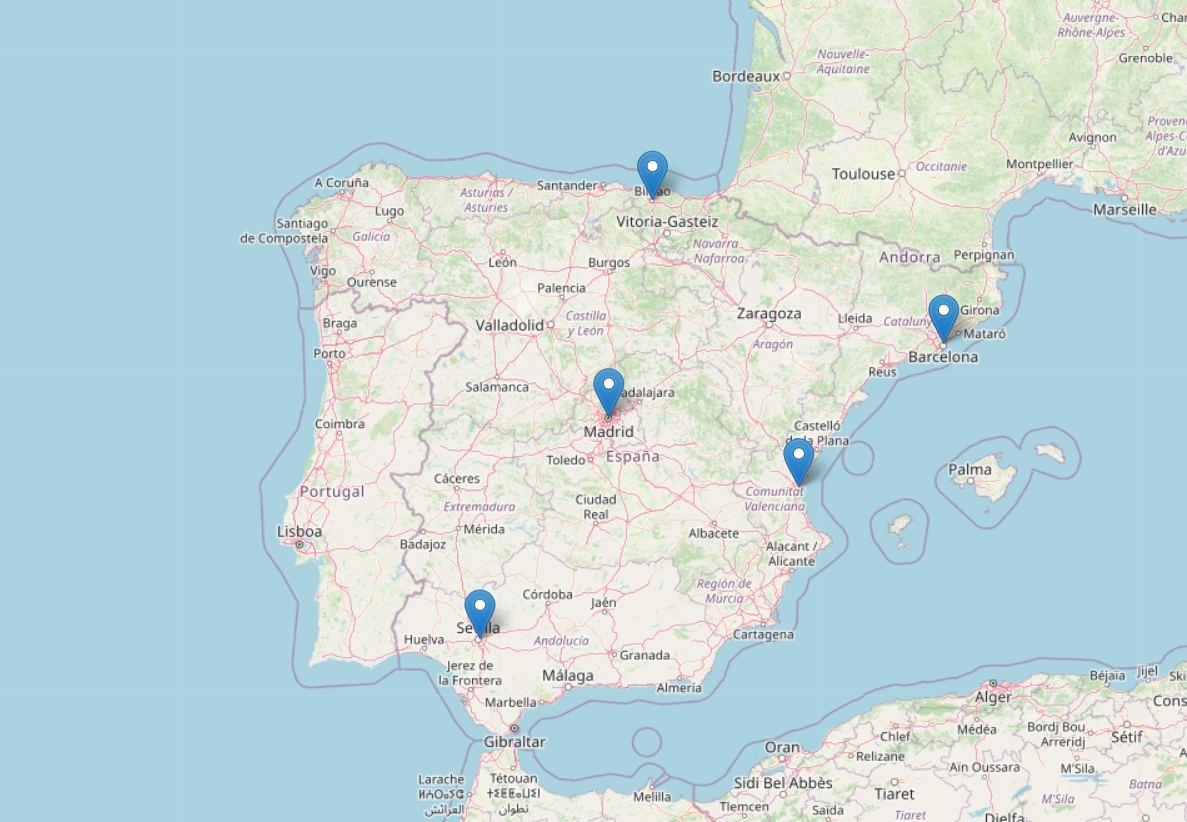

In [1]:
from IPython.display import Image
Image(filename='images/spain-map.png')

Featured above is a map of the 5 cities which we have weather information for. As stated previously, these are Barcelona, Bilbao, Madrid, Seville, and Valencia. 

# Setup

In [2]:
# Importing required packages
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [3]:
# Blocking warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

# Setting plot style
sns.set()

# 1. Data Importing and Cleaning

## 1.1 Energy Dataset

In [4]:
# Reading data
energy_df = pd.read_csv('data/energy_dataset.csv', index_col='time')

# Converting index to datetime format
energy_df.index = pd.to_datetime(energy_df.index, utc=True)

In [5]:
energy_df.head()

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation fossil coal-derived gas  \
time                                                            
2014-12-31 23:00:00+00:00                                 0.0   
2015-01-01 00:00:00+00:00                                 0.0   
2015-01-01 01:00:00+00:00                                 0.0   
2015-01-01 02:00:00+00:00                                 0.0   
2015-01-01 03:00:00+00:00                                 0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   

                           generation fossil oil  generation fossil oil shale  \
time                                                                            
2014-12-31 23:00:00+00:00                  162.0                          0.0   
2015-01-01 00:00:00+00:00                  158.0                          0.0   
2015-01-01 01:00:00+00:00                  157.0                          0.0   
2015-01-01 02:00:00+00:00                  160.0                          0.0   
2015-01-01 03:00:00+00:00                  156.0                          0.0   

                           generation fossil peat  generation geothermal  \
time                                                                       
2014-12-31 23:00:00+00:00                     0.0                    0.0   
2015-01-01 00:00:00+00:00                     0.0                    0.0   
2015-01-01 01:00:00+00:00                     0.0                    0.0   
2015-01-01 02:00:00+00:00                     0.0                    0.0   
2015-01-01 03:00:00+00:00                     0.0                    0.0   

                           generation hydro pumped storage aggregated  \
time                                                                    
2014-12-31 23:00:00+00:00                                         NaN   
2015-01-01 00:00:00+00:00                                         NaN   
2015-01-01 01:00:00+00:00                                         NaN   
2015-01-01 02:00:00+00:00                                         NaN   
2015-01-01 03:00:00+00:00                                         NaN   

                           generation hydro pumped storage consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   

                           generation hydro run-of-river 

In [6]:
energy_df.describe().round(2)

generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0               35046.00   
mean                                  0.0                5622.74   
std                                   0.0                2201.83   
min                                   0.0                   0.00   
25%                                   0.0                4126.00   
50%                                   0.0                4969.00   
75%                                   0.0                6429.00   
max                                   0.0               20034.00   

       generation fossil hard coal  generation fossil oil  \
count                     35046.00               35045.00   
mean                       4256.07                 298.32   
std                        1961.60                  52.52   
min                           0.00                   0.00   
25%                        2527.00                 263.00   
50%                        4474.00                 300.00   
75%                        5838.75                 330.00   
max                        8359.00                 449.00   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  \
count                35046.0                                         0.0   
mean                     0.0                                         NaN   
std                      0.0                                         NaN   
min                      0.0                                         NaN   
25%                      0.0                                         NaN   
50%                      0.0                                         NaN   
75%                      0.0                                         NaN   
max                      0.0                                         NaN   

       generation hydro pumped storage consumption  \
count                                     35045.00   
mean                                        475.58   
std                                         792.41   
min                                           0.00   
25%                                           0.00   
50%                                          68.00   
75%                                         616.00   
max                                        4523.00   

       generation hydro run-of-river and poundage  \
count                                    35045.00   
mean                                       972.12   
std                                        400.78   
min                                          0.00   
25%                                        637.00   
50%                                        906.00   
75%                                       1250.00   
max                                       2000.00   

       generation hydro water r

From the description of the dataframe, we find that a number of columns have mean and maximum values of 0 This is likely indicative that all row values of these columns are 0. To remove these extraneous columns we will drop any columns with all zero/NaN values. In addition, we will remove columns which include forecasting data, as we would like to make our own forecasts. This returns a dataset with only relevant columns.

In [7]:
# Select columns where the max is not equal to 0 or NaN
column_max = energy_df.max()
columns_to_keep = column_max[(column_max != 0) & (~column_max.isna())].index
energy_df = energy_df[columns_to_keep]

# dropping forecast columns
forecast_cols = [col for col in energy_df.columns if 'forecast' in col]
energy_df = energy_df.drop(columns=forecast_cols)

We now check for null and duplicate values in the remaining columns. Upon finding the null values, we will interpolate them to obtain a dataset entirely populated by numeric data.

In [8]:
# Checking null values
energy_df.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [9]:
# Checking duplicates
print("Number of duplicates in energy_df:", energy_df.duplicated().sum())

Number of duplicates in energy_df: 0


we see that many of our columns have null values and none of our columns have duplicates. To fix our null values, we will them using linear interpolation.

In [10]:
# Interpolating null values
energy_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

# Verifying that null values are no longer present
energy_df.isnull().sum(axis=0)

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

Finally, we check for outliers within the energy_df. We do so by normalizing our data and plotting each column as a boxplot. This can be seen below.

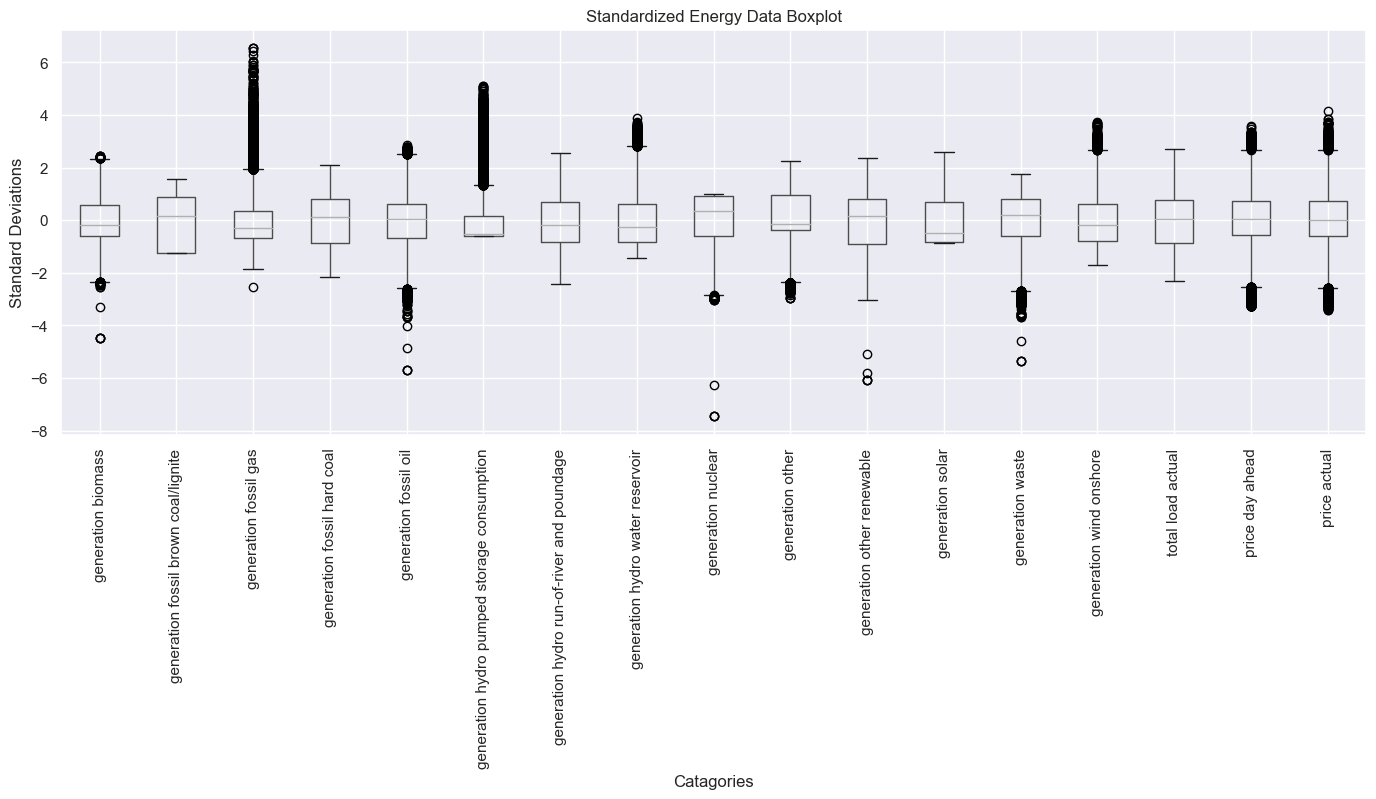

In [11]:
# Standardizing columns
standardized_energy_df = (energy_df - energy_df.mean()) / energy_df.std()

# Creating and labelling boxplot
standardized_energy_df.boxplot(figsize = (15,5))
plt.title('Standardized Energy Data Boxplot')
plt.ylabel('Standard Deviations')
plt.xlabel('Catagories')
plt.xticks(rotation = 90)
plt.show()

Examining the boxplot, it's evident that no extreme outliers significantly deviate from a sensible data range. Consequently, we can confidently deduce that all data points fall within an acceptable value range.

Having confirmed the absence of duplicates, null entries, or conspicuous outliers in the energy_df, we can be assured that our dataframe is now cleansed and ready for integration into the training pipeline of ML models.

## 1.2 Weather Dataset

In [12]:
# Uploading weather dataset
weather_df = pd.read_csv('data/weather_features.csv', index_col= 'dt_iso')

# Correctly formatting the index column
weather_df.index = pd.to_datetime(weather_df.index, utc=True)

# Renaming index for simplicity
weather_df.index.name = 'time'

In [13]:
weather_df.head()

city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2014-12-31 23:00:00+00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 00:00:00+00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00+00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 02:00:00+00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00+00:00  Valencia  269.686   269.686   269.686      1002   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2014-12-31 23:00:00+00:00        77           1        62      0.0      0.0   
2015-01-01 00:00:00+00:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00+00:00        78           0        23      0.0      0.0   
2015-01-01 02:00:00+00:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00+00:00        78           0        23      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
time                                                                      
2014-12-31 23:00:00+00:00      0.0           0         800        clear   
2015-01-01 00:00:00+00:00      0.0           0         800        clear   
2015-01-01 01:00:00+00:00      0.0           0         800        clear   
2015-01-01 02:00:00+00:00      0.0           0         800        clear   
2015-01-01 03:00:00+00:00      0.0           0         800        clear   

                          weather_description weather_icon  
time                                                        
2014-12-31 23:00:00+00:00        sky is clear          01n  
2015-01-01 00:00:00+00:00        sky is clear          01n  
2015-01-01 01:00:00+00:00        sky is clear          01n  
2015-01-01 02:00:00+00:00        sky is clear          01n  
2015-01-01 03:00:00+00:00        sky is clear          01n

In [14]:
weather_df.describe().round(2)

temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00   178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09     1069.26      68.42        2.47   
std         8.03       7.96       8.61     5969.63      21.90        2.10   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.48     284.65     1013.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.73     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  weather_id  
count  178396.00  178396.00  178396.00  178396.00   178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07      759.83  
std       116.61       0.40       0.01       0.22       30.77      108.73  
min         0.00       0.00       0.00       0.00        0.00      200.00  
25%        55.00       0.00       0.00       0.00        0.00      800.00  
50%       177.00       0.00       0.00       0.00       20.00      800.00  
75%       270.00       0.00       0.00       0.00       40.00      801.00  
max       360.00      12.00       2.32      21.50      100.00      804.00

From the dataframe description, a number of things stand out. These are listed below:

* The ***rain_3h*** column doesn't make sense. The rain_1h and rain_3h columns specificy the amount of rainfall which occured in the previous 1 and 3 hours, respectively. The rain_3h column is erronous because it has a lower mean value than the rain_1h column. If it were correct, it would be larger. For this reason, we will drop the column. We now check for null values in the dataset.

* Some columns have extremely high standard deviations. Examining the ***pressure*** collumn especially, we find a massive standard deviation. We should examine the outliers of all columns in more detail.

* The maximum value in the ***wind_speed*** column, we find the maximum value to be very high. Becuase wind speeds are measured in $m/s$, the maximum value of $133~m/s$ equates to about $479~km/h$. This is on par with the fastest wind speeds ever recorded on earth [1], and higher than any wind speed over recorded in Spain, thus should be further examined.

To mitigate these concerns we start by dropping the ***rain_3h*** column.

In [15]:
# Dropping rain_3h column
weather_df.drop('rain_3h', axis=1, inplace=True)

### 1.2.1 Examining Outliers

To examine outliers, we extract numerical columns and standardize them such that they can all be inspected on a boxplot with the same axis.

In [16]:
# Defining catagorical columns
drop_cols = ['weather_id', 'weather_main', 'weather_description', 'weather_icon', 'city_name']

# Creating new dataframe with all numerical columns
weather_df_nums = weather_df.drop(drop_cols, axis = 1)

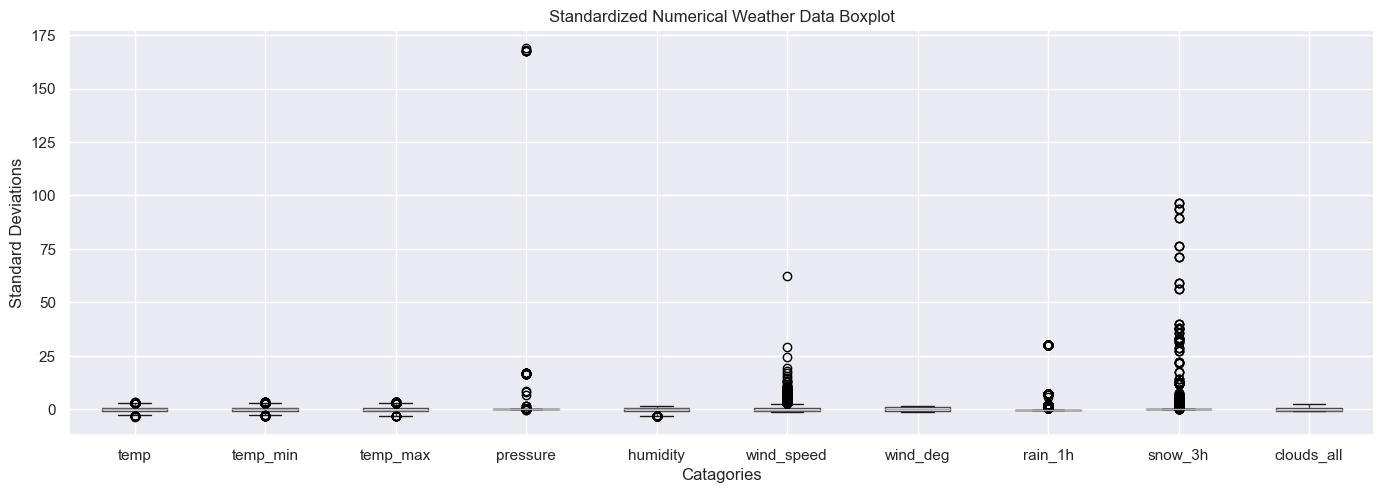

In [17]:
# Normalizing columns
standardized_weather_df = (weather_df_nums - weather_df_nums.mean()) / weather_df_nums.std()

# Creating and labelling boxplot
standardized_weather_df.boxplot(figsize = (15,5))
plt.title('Standardized Numerical Weather Data Boxplot')
plt.ylabel('Standard Deviations')
plt.xlabel('Catagories')
plt.show()

From the boxplot, we see that ***pressure, wind_speed, rain_1h, and snow_3h*** columns have extreme outliers. We will examine each of these individually, starting with ***pressure***.

In [18]:
def box_plotter(df, column, title="Data", xlabel=None, figsize=(15,3)):
    """
    Plots a box plot for a specified column of a dataframe.
    
    Parameters:
    - df (DataFrame): The dataframe containing the data.
    - column (str): The column name in the dataframe for which the box plot is to be generated.
    - title (str, optional): The title for the plot. Defaults to "Data".
    - xlabel (str, optional): The x-axis label. If not provided, the x-axis will have no specific label.
    - figsize (tuple, optional): Tuple indicating the width and height of the figure. Defaults to (15,3).
    
    Returns:
    - None: Displays the box plot.
    """
    plt.figure(figsize=figsize)
    sns.boxplot(x=df[column])
    plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.show()


**Presure Data**

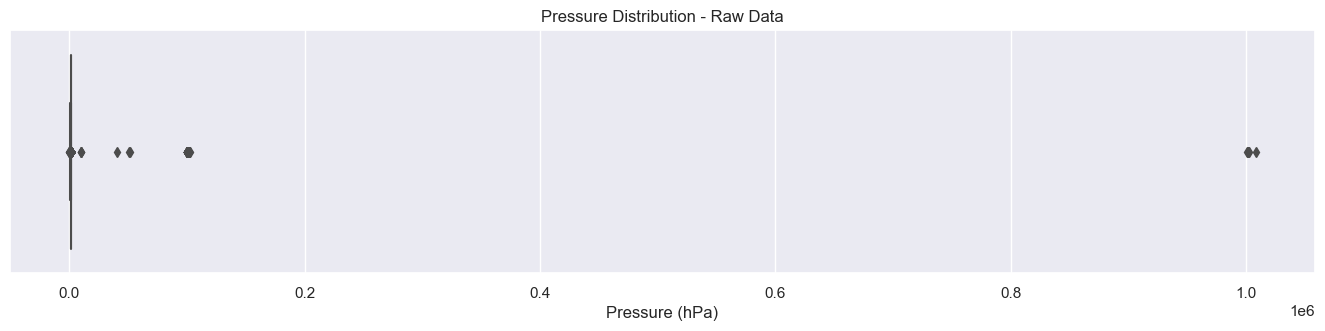

In [19]:
# Raw pressure data boxplot
box_plotter(weather_df, 'pressure', title='Pressure Distribution - Raw Data', xlabel='Pressure (hPa)')

From the pressure data, we see that there are some pretty extreme outliers. The highest recorded pressure is approximately $ 10^6~hPa$, which is a pressure similar to that at the bottom of the Mariana Trench [2]. This is obviously not a correct measurement.

Furthermore, the highest and lowest pressures ever recorded in Spain were $1051~hPa$  and $950~hPa$ respectively [3]. Beucause of this, we will ignore all data with pressure readings outside of this range.

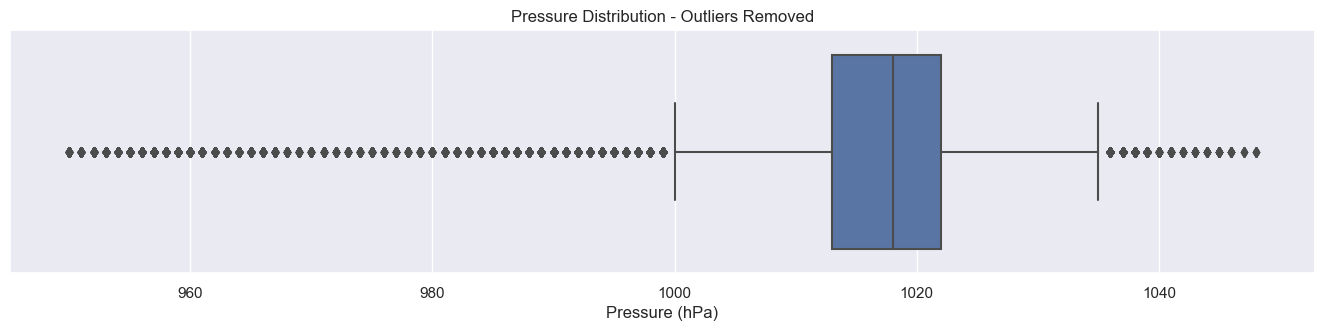

In [20]:
# Removing outliers
weather_df.loc[(weather_df['pressure'] > 1051) | (weather_df['pressure'] < 950), 'pressure'] = np.nan

# Replotting pressure data with outliers removed
box_plotter(weather_df, 'pressure', title='Pressure Distribution - Outliers Removed', xlabel='Pressure (hPa)')

**Wind Speed**

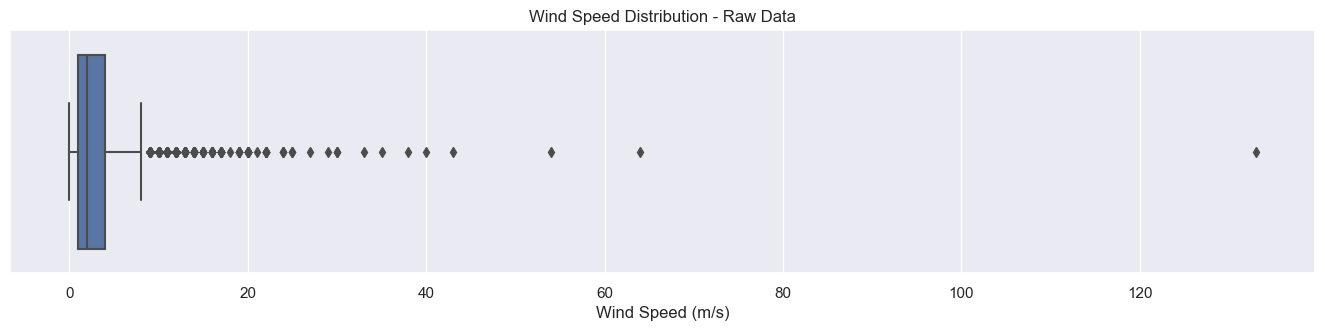

In [21]:
# Raw wind speed boxplot
box_plotter(weather_df, 'wind_speed', title='Wind Speed Distribution - Raw Data', xlabel='Wind Speed (m/s)')

We see that there is a pretty obvious outlier in this dataset. As previously mentioned, the  $133~m/s$ wind recorded would be faster than any wind speed recorded in Spain. For reference the highest wind speed ever recorded in Spain are approximately $200~km/h$ or about $56~m/s$. Because of this we will remove any data with wind speeds higher than $50~m/s$.

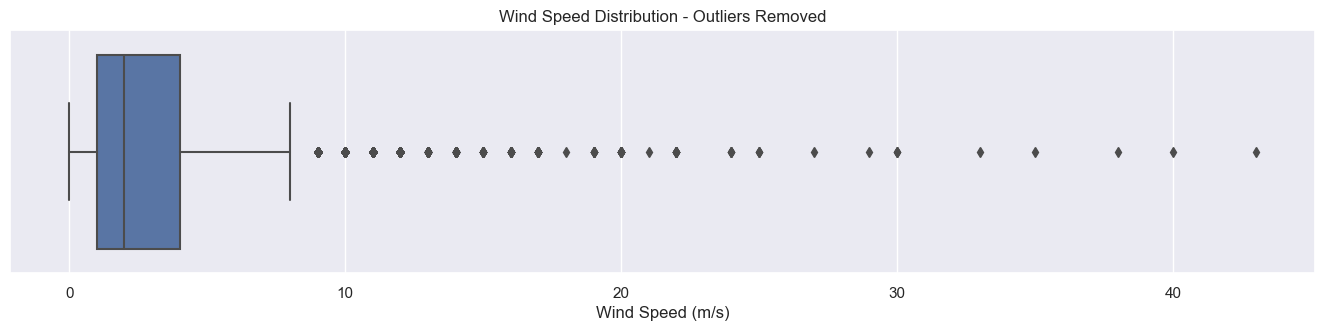

In [22]:
# Removing outliers
weather_df.loc[weather_df['wind_speed'] > 50, 'wind_speed'] = np.nan

# Replotting wind speed data with outliers removed
box_plotter(weather_df, 'wind_speed', title='Wind Speed Distribution - Outliers Removed', xlabel='Wind Speed (m/s)')


**Rainfall**

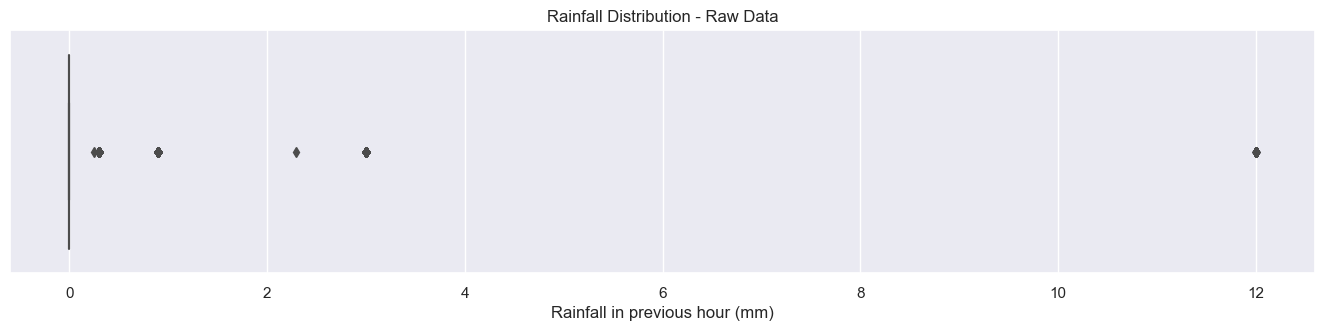

In [23]:
# Raw rainfall 1h boxplot
box_plotter(weather_df, 'rain_1h', title='Rainfall Distribution - Raw Data', xlabel='Rainfall in previous hour (mm)')

From research, it is clear that Spanish rainfalls of $100~mm/hour$ are possible [4]. Therefor, it is reasonable to assume that the $12~mm$ readings are entirely reasonable and do not need to be removed. Finally, we examing the ***snow_3h*** column.

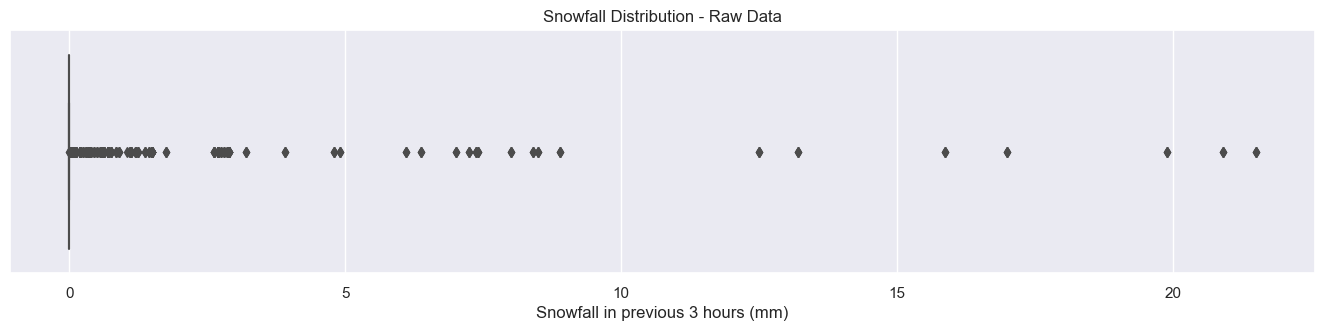

In [24]:
# Raw snowfall 3h boxplot 
box_plotter(weather_df, 'snow_3h', title='Snowfall Distribution - Raw Data', xlabel='Snowfall in previous 3 hours (mm)')

Examining the snowfall boxplot, it is reasonable to assume that $20~mm$ of snowfall in 3 hours is entirely possible. Therefor, we will not be removing any of the snowfall data.

### 1.2.2 Cleaning Weather Dataframe

Before the eventual joining of our weather and energy dataframes, we must ensure the following:

1. **The weather dataframe is formatted correctly.**  
Currently, the weather dataframe is formatted in a way which is not condusive to joining. The time series index is not continuous, and restarts its index each time there is a unique new entry in the **city_name** column. In order for a join to take place, there must be a single index time series value, with no repeat entries dependent on the city.

2. **There must be matching index values.**  
Upon correctly formatting, there must be matching index values between the weather and energy dataframes.

3. **There must be no missing or duplicated values in either dataframe.**  
We have already ensured that there are no missing values or duplicate values in the energy dataframe. We must now ensure the same for the weather dataframe.

4. **There is no redunancy within the columns.**  
Before formatting this dataframe, we should drop any redundant columns as it will be more difficult to do so upon formatting.

To begin this process, we will examine the duplicated values in the weather dataframe.

In [25]:
# Total number of duplicate values
num_duplicated = weather_df.duplicated(keep=False).sum()
print('The total number of duplicate values in weather_df is:', num_duplicated)

The total number of duplicate values in weather_df is: 14186


It appears there a high number of duplicate values within weather_df. We now examine the number entires for each city and see if this aligns with our energy_df

In [26]:
print('The length of the energy_df is:', len(energy_df))
print('\nThe lengths of data associated with each of the cities are:')

with_duplicates = weather_df['city_name'].value_counts()
print(with_duplicates)

The length of the energy_df is: 35064

The lengths of data associated with each of the cities are:
city_name
Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: count, dtype: int64


From this analysis, there appears to be many more entires for each the cities in weather_df than there are total entries in energy_df. We need to ensure that these numbers match up. The reason for this discrepancy could be due to the high number of duplicates in the weather_df. We will examine the  duplicates of the weather_df, subsetting on ***city_name*** and ***time***

In [27]:
# Creating boolean series which returns true when 'time' and 'city_name' value pairs are repeated.
duplicated_bool = weather_df.reset_index().duplicated(subset=['time', 'city_name'], keep=False)

In [28]:
# Subsetting weather dataframe based on boolean duplicate series
duplicated_data = weather_df.reset_index()[duplicated_bool].sort_values('time')

# Showing sample of duplicate values
duplicated_data.head()

time   city_name     temp  temp_min  temp_max  \
124    2015-01-06 03:00:00+00:00    Valencia  273.142   273.142   273.142   
125    2015-01-06 03:00:00+00:00    Valencia  273.142   273.142   273.142   
144334 2015-03-04 05:00:00+00:00     Seville  288.470   285.150   291.150   
144333 2015-03-04 05:00:00+00:00     Seville  288.470   285.150   291.150   
109256 2015-03-20 20:00:00+00:00   Barcelona  286.810   282.590   291.480   

        pressure  humidity  wind_speed  wind_deg  rain_1h  snow_3h  \
124        995.0        86         1.0       265      0.0      0.0   
125        995.0        86         1.0       265      0.0      0.0   
144334    1026.0       100         1.0        62      0.0      0.0   
144333    1026.0       100         1.0        62      0.0      0.0   
109256    1013.0        76        12.0        50      0.3      0.0   

        clouds_all  weather_id weather_main weather_description weather_icon  
124              0         800        clear        sky is clear          01n  
125              0         800        clear        sky is clear          01n  
144334          75         741          fog                 fog          50n  
144333          75         701         mist                mist          50n  
109256          40         500         rain          light rain          10n

From our sample of duplicate values above, we can see that the duplicate values are the same in many regards. However, they do appear to differ in qualitative metrics such as ***weather_id***, ***weather_main***, ***weather_description***, and ***weather_icon***. We will now examine the quantities of duplicates values, and dive deeper into their characteristics.

In [29]:
duplicate_counts = duplicated_data.groupby(['time', 'city_name']).size()

duplicate_points = duplicate_counts.unique()
print("There are datapoints with the following number of duplicates:", duplicate_points)

There are datapoints with the following number of duplicates: [2 3 4]


Now that we know the quantities of duplicate values, we will examine datapoints which each have 4 duplicates associated with them.

In [30]:
# Determining indices of data points with 4 duplicate values
indices = duplicate_counts[duplicate_counts==4].index

# Dinding data points with 4 duplicate values
data_with_four_duplicates = duplicated_data[duplicated_data.set_index(['time', 'city_name']).index.isin(indices)]

data_with_four_duplicates.head()

time city_name    temp  temp_min  temp_max  \
51839 2016-11-20 17:00:00+00:00    Madrid  282.78    280.15    284.15   
51838 2016-11-20 17:00:00+00:00    Madrid  282.78    280.15    284.15   
51841 2016-11-20 17:00:00+00:00    Madrid  282.78    280.15    284.15   
51840 2016-11-20 17:00:00+00:00    Madrid  282.78    280.15    284.15   
53617 2017-01-27 12:00:00+00:00    Madrid  277.78    276.15    279.15   

       pressure  humidity  wind_speed  wind_deg  rain_1h  snow_3h  clouds_all  \
51839    1007.0       100         1.0       280      0.9      0.0          75   
51838    1007.0       100         1.0       280      0.9      0.0          75   
51841    1007.0       100         1.0       280      0.9      0.0          75   
51840    1007.0       100         1.0       280      0.9      0.0          75   
53617    1008.0       100         3.0       340      0.9      0.0          75   

       weather_id weather_main weather_description weather_icon  
51839         701         mist                mist          50d  
51838         501         rain       moderate rain          10d  
51841         741          fog                 fog          50d  
51840         301      drizzle             drizzle          09d  
53617         501         rain       moderate rain          10d

Examining the data points with 4 duplicate values, we find that much of the data remains constant between the duplicates other than the qualitative descriptions of weather. This may be due to weather conditions updating over the course of the hour, and the software which created this dataset failing to update the time column. In order to keep the qualitative descriptions of weather we will drop all duplicate values from the dataset, but keep the first value of each duplicate.

This is justified by the fact that general weather descriptions appear to remain consistent between duplicates. For example, in the first 4 rows of the columns above, we have that the ***weather_main*** column goes from mist, to rain, to fog, to drizzle. These descriptions follow a similar pattern, and if we select the first of these values, there will be a general indication of how the weather during the hour behaved. 

In [31]:
# Dropping duplicate values from weather_df
weather_df = weather_df.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

Now that we have dropped the duplicates from the duplicates from the dataframe, we will check to see if we have the same number of weather_df rows as energy_df rows.

In [32]:
print('The length of the energy_df is:', len(energy_df))
print('\nThe lengths of data associated with each of the cities are:')
print(weather_df['city_name'].value_counts())

The length of the energy_df is: 35064

The lengths of data associated with each of the cities are:
city_name
Valencia      35064
Madrid        35064
Bilbao        35064
 Barcelona    35064
Seville       35064
Name: count, dtype: int64


We can now see that our number of rows lines up. As a double check, we see if our index for each city in weather_df lines up with the index of the energy_df.

In [33]:
for city in weather_df['city_name'].unique():
    equal = weather_df[weather_df['city_name']==city].index.equals(energy_df.index)
    print('The time index associated with {} is equal to energy_df index: {}'.format(city, equal))


The time index associated with Valencia is equal to energy_df index: True
The time index associated with Madrid is equal to energy_df index: True
The time index associated with Bilbao is equal to energy_df index: True
The time index associated with  Barcelona is equal to energy_df index: True
The time index associated with Seville is equal to energy_df index: True


### 1.2.3 Removing Redundant Columns

The removal of redundant columns is necessay in this step due to the fact that it will be more difficult once the dataframe has been properly formatted. While it appears that all quantitative data will be useful in determining energy prices and load, there may be some redundancy between the qualitative/catagorical columns. The qualitative columns under investigation in this section are: ***weather_id***, ***weather_main***, ***weather_description***, and ***weather_icon***.

To determine which of these columns will be useful in our analysis, we will create a histogram to examine there labels and frequencies.

In [34]:
def plot_histograms(df, columns, titles=None, figsize=(15,3)):
    
    n = len(columns)

    # If no titles are provided, use default titles
    if not titles:
        titles = [f'Histogram of {col}' for col in columns]
    
    # If provided titles don't match the number of columns, raise an error
    if len(titles) != n:
        raise ValueError("Number of titles should match the number of columns.")

    # Plot histograms for each column
    for i, col in enumerate(columns):
        plt.figure(figsize=figsize)
        df[col].value_counts().plot(kind='bar')
        plt.tick_params(axis='x', rotation=90)
        plt.title(titles[i])
        plt.xlabel('Frequency')
        plt.show()

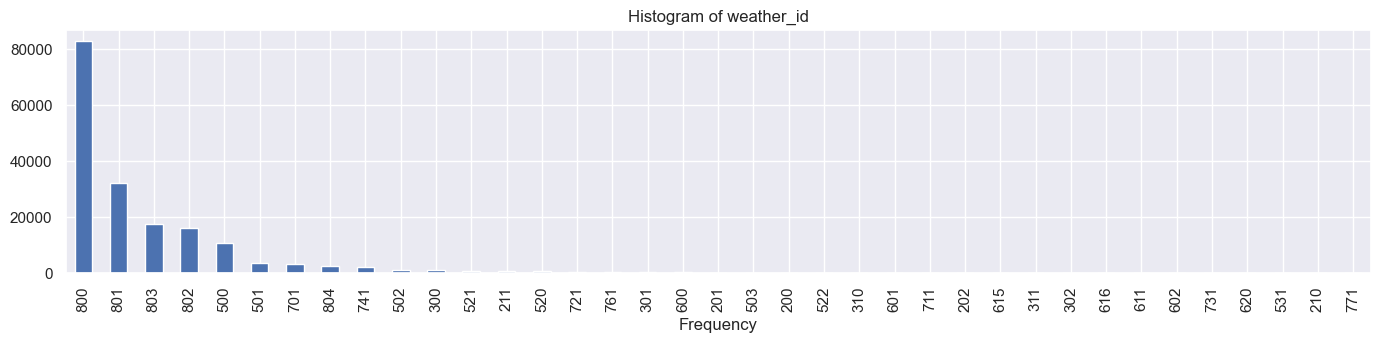

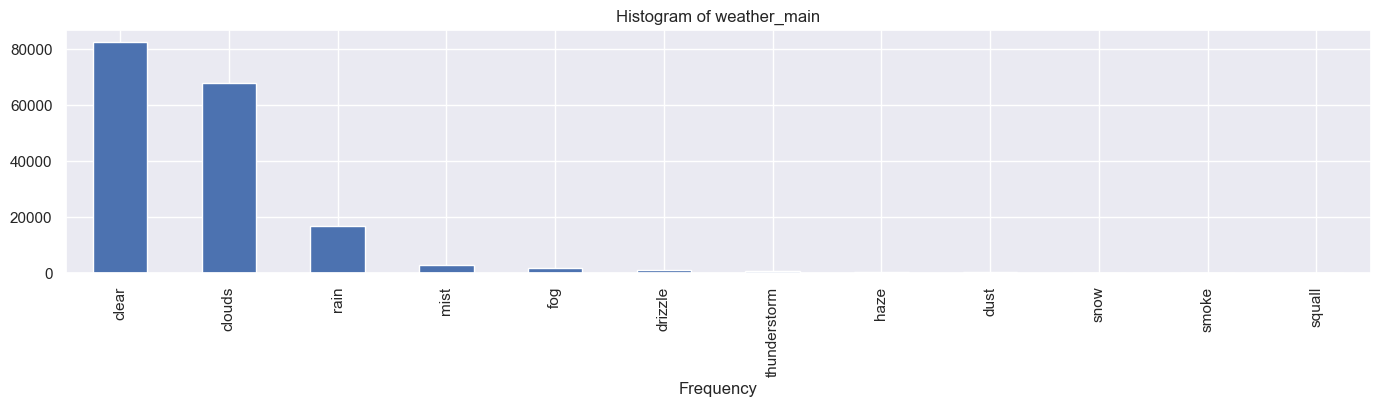

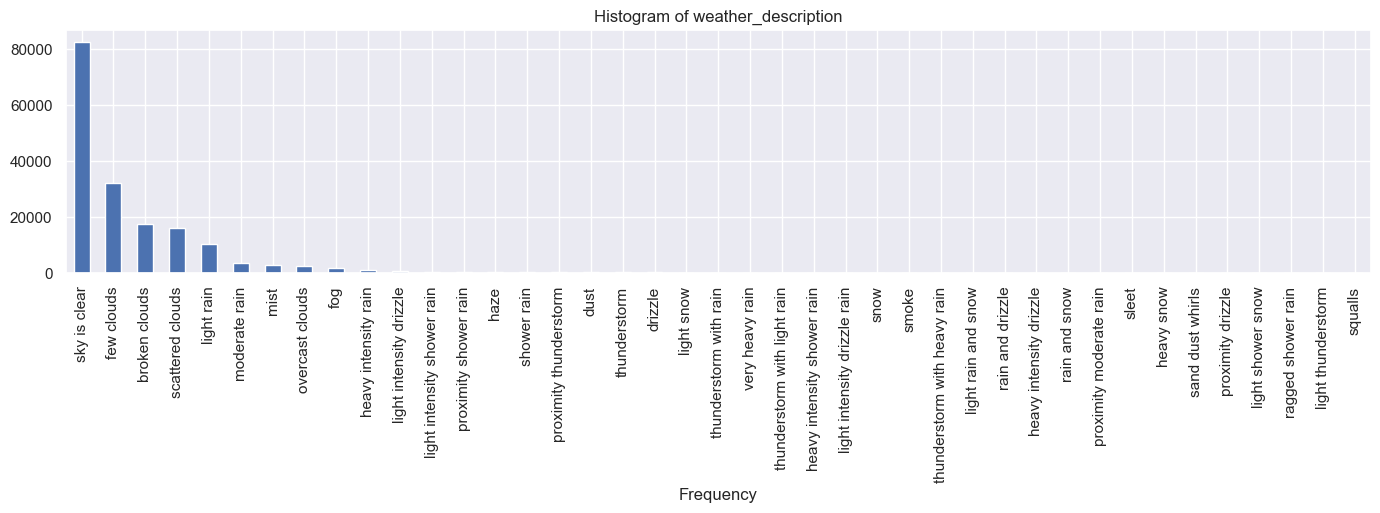

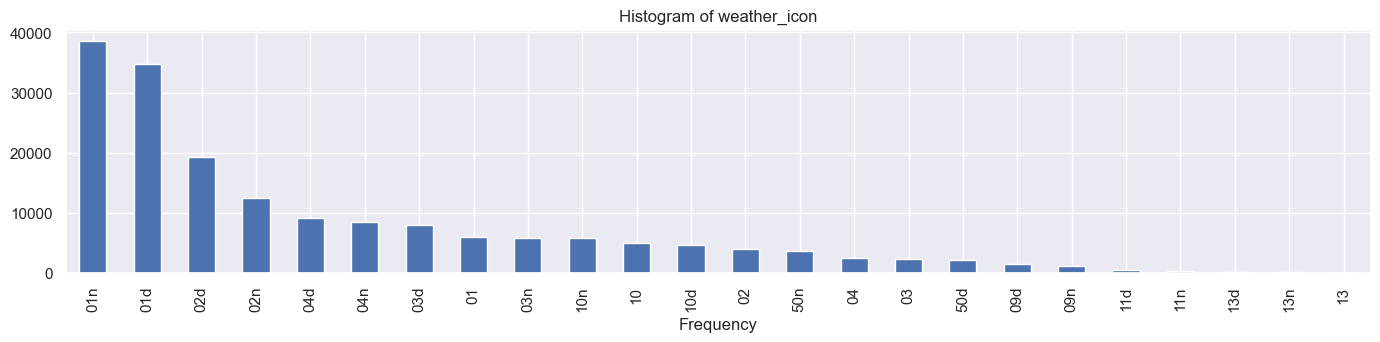

In [35]:
plot_histograms(weather_df, columns=['weather_id', 'weather_main', 'weather_description', 'weather_icon'], titles=None)

Examining the catagorical columns, we find that that they all have different numbers of unique values, but follow similar frequency distributions. In deciding which columns to drop, it would make sense that ***weather_icon*** and ***weather_id*** should go. It is unclear what these columns mean, and if deemed important in the forecasting model, may result in dependance on a feature that is not understood. **Therefore, we choose to drop _weather_icon_ and _weather_id_.**

Moving forward, we are left with ***weather_description***, and ***weather_main***. Because they convey largely the same information, I will just use one of them. In picking between the two variables, there are a few things we must consider.

* ***Descriptiveness*** - It is evident that _weather_description_ is much more comprehensive in its descriptions than _weather_main_. This will allow us to gain more insights from the variable.

* ***Class Distribution*** - Although neither variables have even class distributions, it is reasonable to say that _weather_main_ has less class imbalance than _weather_description_. This would be potentially beneficial in greating a more generalized model.

* ***Redundancy*** - Many of the features of the _weather_main_ could be described by other columns in the dataframe. For example, the _'rain'_ catagory is easily inferred through other variables such as _'rain_1h'_. The more detailed descriptions in _weather_description_ may provide more contect to the model and lead to less redundancy.

For the reasons listed above, we will decide to keep ***weather_description*** as one of our model paramters.

In [36]:
# Listing catagorical columns to drop
catagorical_cols_drop = ['weather_id', 'weather_main', 'weather_icon']

# Dropping specified columns
weather_df.drop(columns=catagorical_cols_drop, inplace=True)

#### Formatting DF

Here, we format our dataframe so that each column value corresponds to data within in a particular city. Ensures that we have a unique time index for each one of our data points and that our weather data can be joined to our energy dataset.

In [37]:
# Intitializing dataframe array
dataframes = []

# Looping through cities
for city in weather_df['city_name'].unique():

    # Filtering dataframe by city and dropping city_name column
    df = weather_df[weather_df['city_name']==city].copy()
    df.drop(columns = 'city_name', inplace=True)

    # Defining new column names
    new_col_names = [col + '_' + city  for col in df.columns]
    df.columns = new_col_names

    # Appending dataframe to array
    dataframes.append(df)

# Concatenating array of dfs to create new dataframe
format_weather_df = pd.concat(dataframes, axis=1)


Upon completing this, we ensure that there are no missing values by linearly interpolating each column of our formatted dataset.

In [38]:
# Interpolating missing values
format_weather_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

## 1.3 Joining Dataframes

In [39]:
# Checking that energy index equals weather index
energy_df.index.equals(format_weather_df.index)

True

In [40]:
# Merging dataframes on time index
df_joined = format_weather_df.merge(energy_df, on='time')

In [41]:
df_joined.head()

temp_Valencia  temp_min_Valencia  \
time                                                          
2014-12-31 23:00:00+00:00        270.475            270.475   
2015-01-01 00:00:00+00:00        270.475            270.475   
2015-01-01 01:00:00+00:00        269.686            269.686   
2015-01-01 02:00:00+00:00        269.686            269.686   
2015-01-01 03:00:00+00:00        269.686            269.686   

                           temp_max_Valencia  pressure_Valencia  \
time                                                              
2014-12-31 23:00:00+00:00            270.475             1001.0   
2015-01-01 00:00:00+00:00            270.475             1001.0   
2015-01-01 01:00:00+00:00            269.686             1002.0   
2015-01-01 02:00:00+00:00            269.686             1002.0   
2015-01-01 03:00:00+00:00            269.686             1002.0   

                           humidity_Valencia  wind_speed_Valencia  \
time                                                                
2014-12-31 23:00:00+00:00                 77                  1.0   
2015-01-01 00:00:00+00:00                 77                  1.0   
2015-01-01 01:00:00+00:00                 78                  0.0   
2015-01-01 02:00:00+00:00                 78                  0.0   
2015-01-01 03:00:00+00:00                 78                  0.0   

                           wind_deg_Valencia  rain_1h_Valencia  \
time                                                             
2014-12-31 23:00:00+00:00                 62               0.0   
2015-01-01 00:00:00+00:00                 62               0.0   
2015-01-01 01:00:00+00:00                 23               0.0   
2015-01-01 02:00:00+00:00                 23               0.0   
2015-01-01 03:00:00+00:00                 23               0.0   

                           snow_3h_Valencia  clouds_all_Valencia  \
time                                                               
2014-12-31 23:00:00+00:00               0.0                    0   
2015-01-01 00:00:00+00:00               0.0                    0   
2015-01-01 01:00:00+00:00               0.0                    0   
2015-01-01 02:00:00+00:00               0.0                    0   
2015-01-01 03:00:00+00:00               0.0                    0   

                          weather_description_Valencia  temp_Madrid  \
time                                                                  
2014-12-31 23:00:00+00:00                 sky is clear      267.325   
2015-01-01 00:00:00+00:00                 sky is clear      267.325   
2015-01-01 01:00:00+00:00                 sky is clear      266.186   
2015-01-01 02:00:00+00:00                 sky is clear      266.186   
2015-01-01 03:00:00+00:00                 sky is clear      266.186   

                           temp_min_Madrid  temp_max_Madrid  pressure_Madrid  \
time                                                                           
2014-12-31 23:00:00+00:00          267.325          267.325            971.0   
2015-01-01 00:00:00+00:00          267.325          267.325            971.0   
2015-01-01 01:00:00+00:00          266.186          266.186            971.0   
2015-01-01 02:00:00+00:00          266.186          266.186            971.0   
2015-01-01 03:00:00+00:00          266.186          266.186            971.0   

                           humidity_Madrid  wind_speed_Madrid  \
time                                                            
2014-12-31 23:00:00+00:00               63                1.0   
2015-01-01 00:00:00+00:00               63                1.0   
2015-01-01 01:00:00+00:00               64                1.0   
2015-01-01 02:00:00+00:00               64                1.0   
2015-01-01 03:00:00+00:00               64                1.0   

                           wind_deg_Madrid  rain_1h_Madrid  snow_3h_Madrid  \
time                                                                         
2014-12-31 23:00:00+

# 2. Exploration and Analysis

## 2.1 Price and Load Data Time Series Data

We start by creating a time series plotting function tailored to our data. This function will serve to visualize the temporal evolution of our dataset. After defining this function, we proceed to graphically depict several crucial variables during the initial 4 weeks of operation. These variables encompass power generation by source, total load, and power prices.

In [42]:
def plot_time_series(data=None, columns=None, title="Time Series Plot", ylabel="Values",
                          subplots=False, start=0, end=None, legend=True, figsize=(15, 5)):
    """
    Plots time series data from a pandas DataFrame or Series.

    Parameters:
    - data (pandas.DataFrame or pandas.Series): Data to be plotted.
    - columns (list or None): Columns to plot from the DataFrame. If None, all columns are plotted.
    - title (str): Title for the plot.
    - ylabel (str): Y-axis label.
    - subplots (bool): If True, plots each column in a separate subplot. Otherwise, plots them on the same axes.
    - start (int): Starting index for slicing the data. Useful for zooming in on a part of the time series.
    - end (int or None): Ending index for slicing the data. Useful for zooming in on a part of the time series.
    - legend (bool): If True, displays the legend.
    - figsize (tuple): Figure size for the plot.

    Returns:
    None. Displays the plot.
    """
    if isinstance(data, pd.DataFrame):
        if columns is None:
            columns = data.columns
        
        selected_data = data[columns][start:end]  # Select data based on start and end index
        
        if not selected_data.empty:
            selected_data.plot(subplots=subplots, figsize=figsize)  # Plot selected data
            
    elif isinstance(data, pd.Series):
        data.plot(figsize=figsize)  # Plot Series data
        legend=False
        
    else:
        raise ValueError("Invalid data type. Expected pandas DataFrame or Series.")

    plt.title(title)  # Set title
    plt.xlabel("Time")
    plt.ylabel(ylabel)

    if legend:
        plt.legend()  # Display legend if legend=True

    plt.show()  # Display the plot


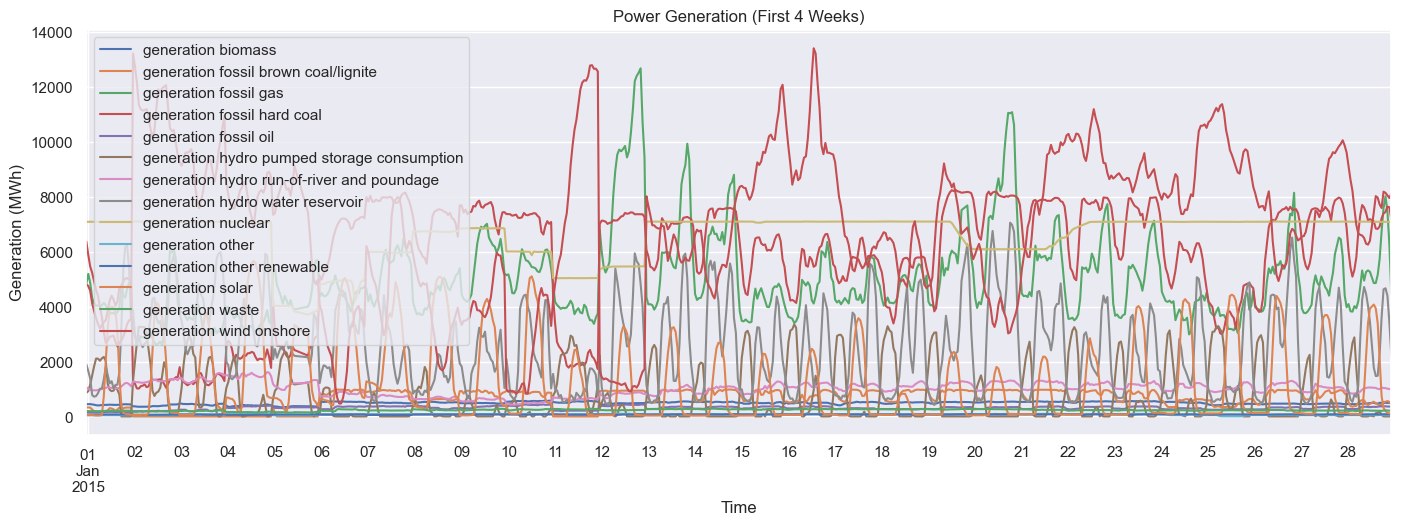

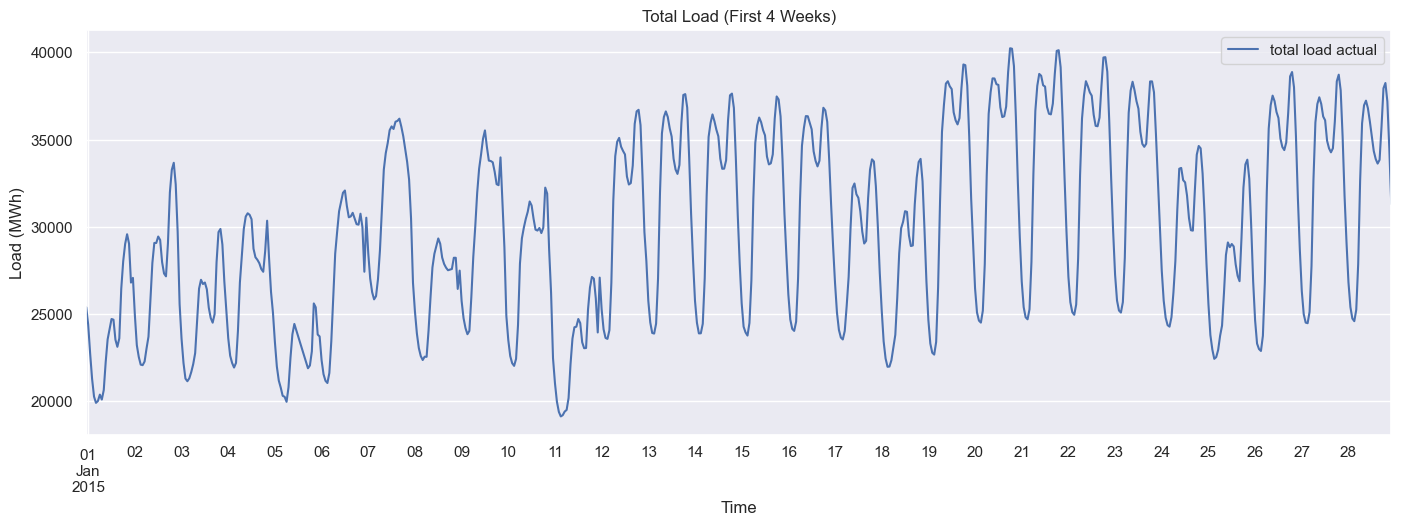

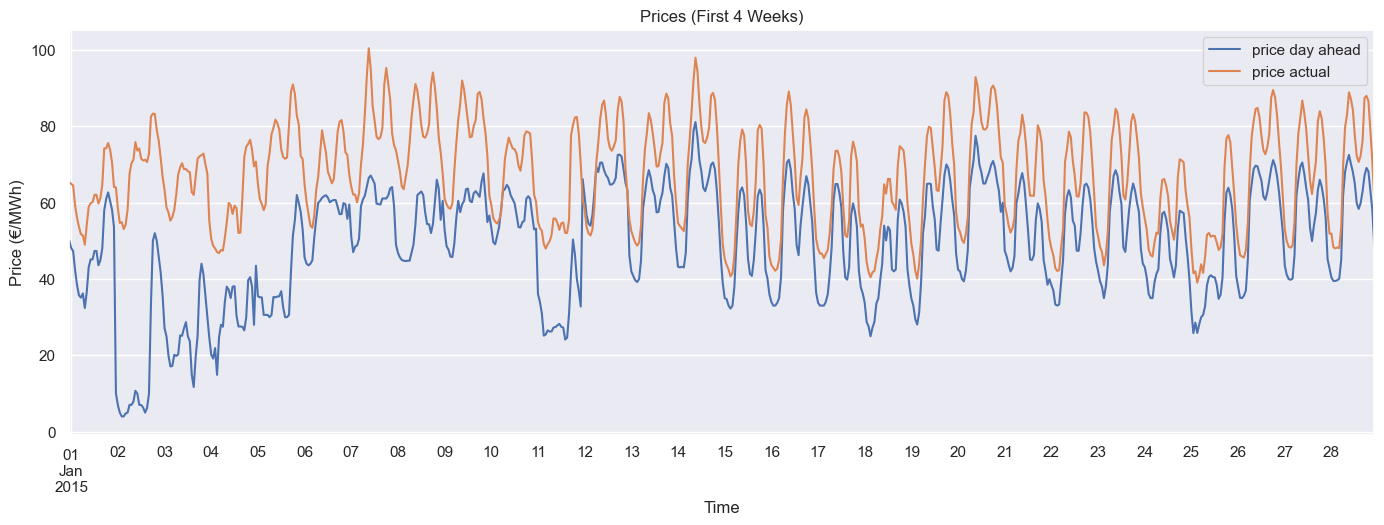

In [43]:
# Defining end date for first 4 weeks
end = 4*7*24

# Plotting relevant characteristics
plot_time_series(energy_df, columns = energy_df.columns[0:14], title='Power Generation (First 4 Weeks)', ylabel="Generation (MWh)", end=end)
plot_time_series(energy_df, columns = energy_df.columns[14], title='Total Load (First 4 Weeks)', ylabel="Load (MWh)", end=end)
plot_time_series(energy_df, columns = energy_df.columns[15:17], title='Prices (First 4 Weeks)', ylabel="Price (€/MWh)", end=end)

Upon analyzing our plotted data, it becomes apparent that columns such as ***total load actual***, ***price actual***, and ***price day ahead*** exhibit periodic patterns. This periodicity will be decomposed and analyzed in our Prophet time series analysis. Additionally, a closer examination of the price data reveals a strong similarity between the trends of ***price actual*** and ***price day ahead***.

We will now extend our investigation to encompass the entire dataset, exploring the price and load data comprehensively.

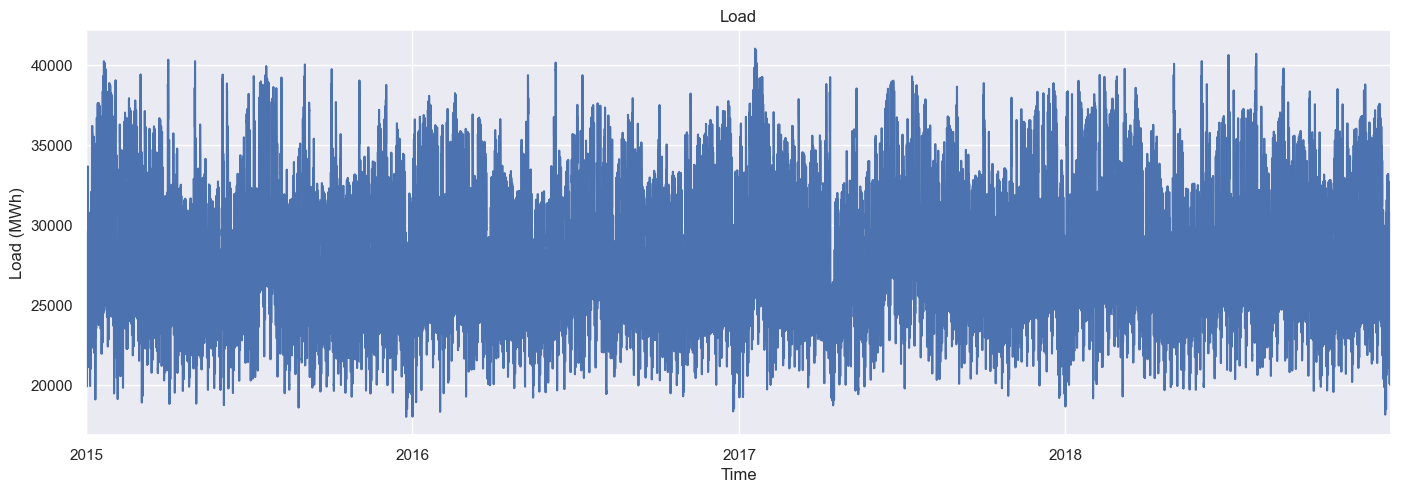

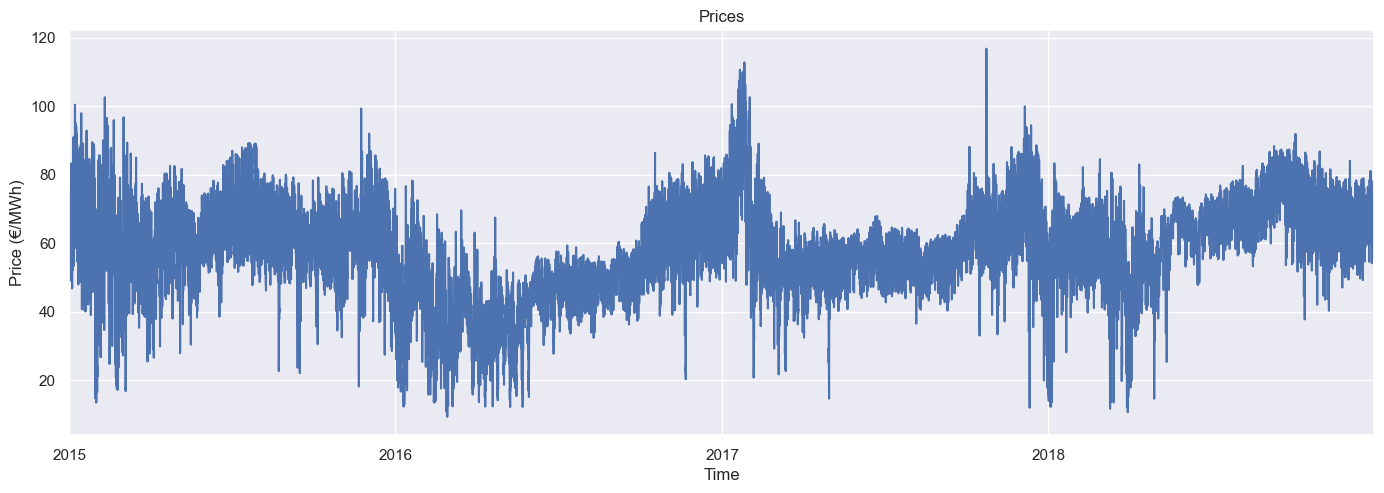

In [44]:
plot_time_series(energy_df['total load actual'], title='Load', ylabel="Load (MWh)")
plot_time_series(energy_df['price actual'], title='Prices', ylabel="Price (€/MWh)")

Upon juxtaposing the price and load time series data, it becomes evident that the ***total load actual*** exhibits a more consistent pattern compared to ***price actual***. To delve deeper into our load and price data analysis, we will graph the hourly percentage changes in load and price, investigating their respective levels of volatility.

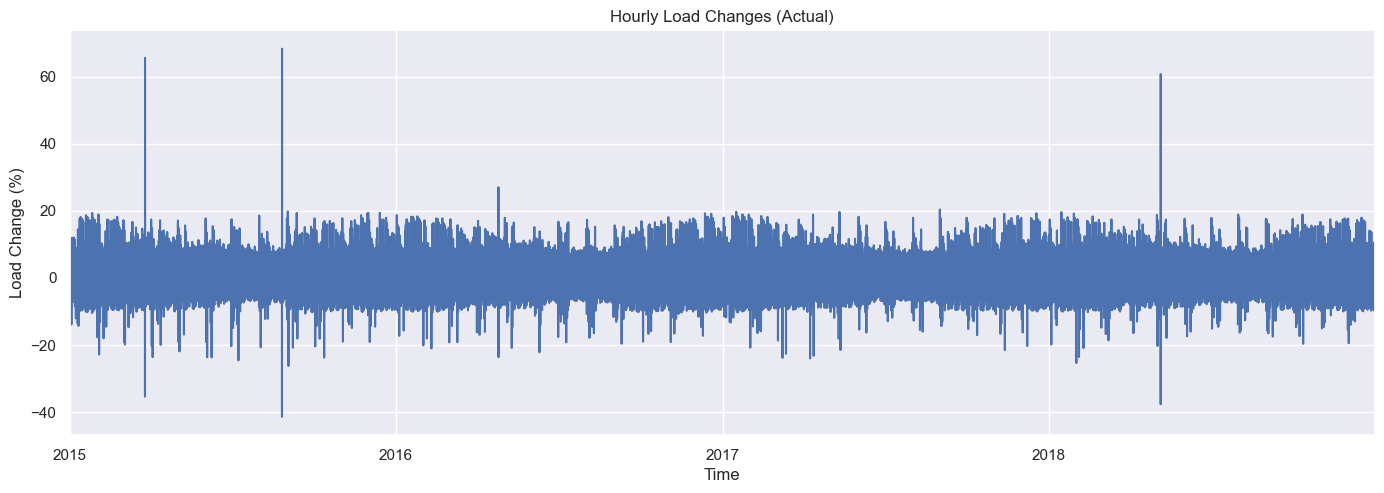

In [45]:
change_in_load = df_joined['total load actual'].pct_change().mul(100)
plot_time_series(data=change_in_load, title='Hourly Load Changes (Actual)', ylabel='Load Change (%)')

Examining the percentage changes in hourly load, a relatively consistent pattern emerges. With the exception of a handful of outliers, significant load fluctuations between consecutive hours appear limited. I dedicated time to exploring correlations associated with the substantial hourly changes, but regrettably, I couldn't uncover a plausible explanation. Consequently, I am proceeding under the premise that these drastic load shifts are attributed to occurrences like blackouts or brownouts.

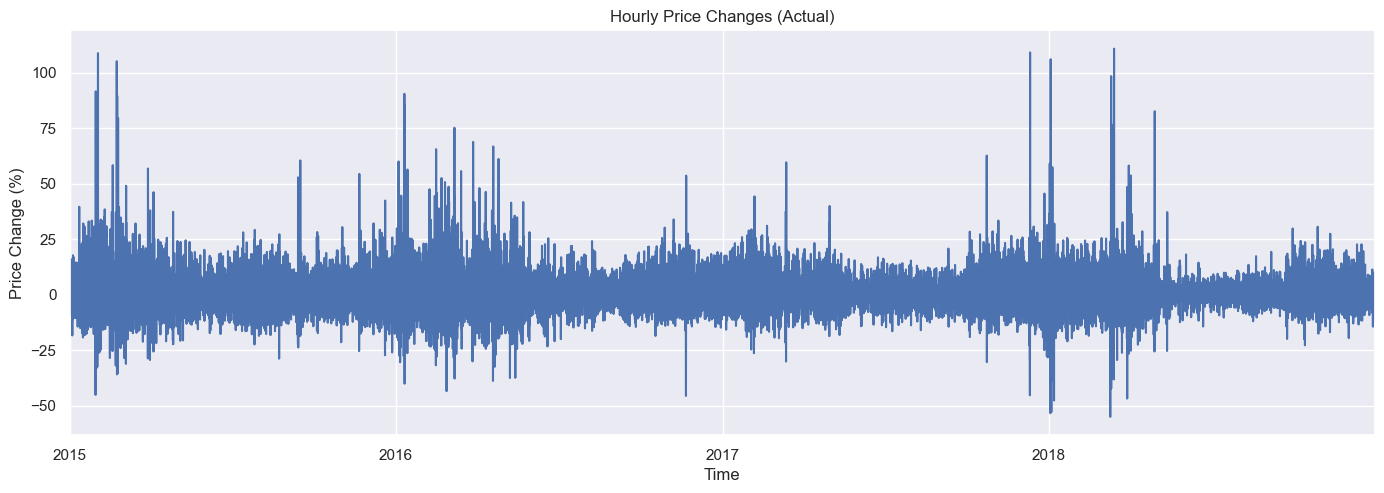

In [46]:
change_in_actual_price = df_joined['price actual'].pct_change().mul(100)
plot_time_series(data=change_in_actual_price, title='Hourly Price Changes (Actual)', ylabel='Price Change (%)')

Price changes exhibit a higher degree of volatility compared to load changes. Their lack of a discernible consistent pattern is coupled with a notable abundance of outliers. This observation suggests that forecasting price might pose a greater challenge in contrast to load prediction.

In [47]:
print('Standard deviation of change in load: {:.2f}'.format(change_in_load.std()))
print('Standard deviation of change actual prices: {:.2f}'.format(change_in_actual_price.std()))

Standard deviation of change in load: 5.14
Standard deviation of change actual prices: 7.50


The standard deviation of changes in ***price actual*** are higher than changes in ***total load actual***. This aligns with what we observed in the figures above. We will now proceed to explore the distribution of prices and load through the use of a violin plot.

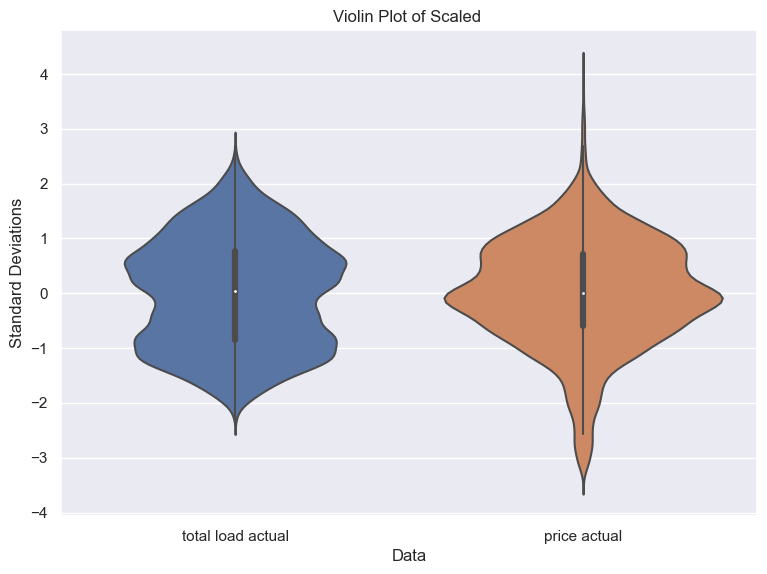

In [48]:
# Combine scaled data into a single column for plotting
scaled_data = pd.melt(standardized_energy_df[['total load actual', 'price actual']],
                      var_name='Data', 
                      value_name='Standard Deviations'
                      )

# Create the violin plot using Seaborn
plt.figure(figsize=(8, 6))
sns.violinplot(x='Data', y='Standard Deviations', data=scaled_data)
plt.title('Violin Plot of Scaled ')
plt.show()


## 2.2 Correlations

To start, we create a heatmap of pearson correlations.

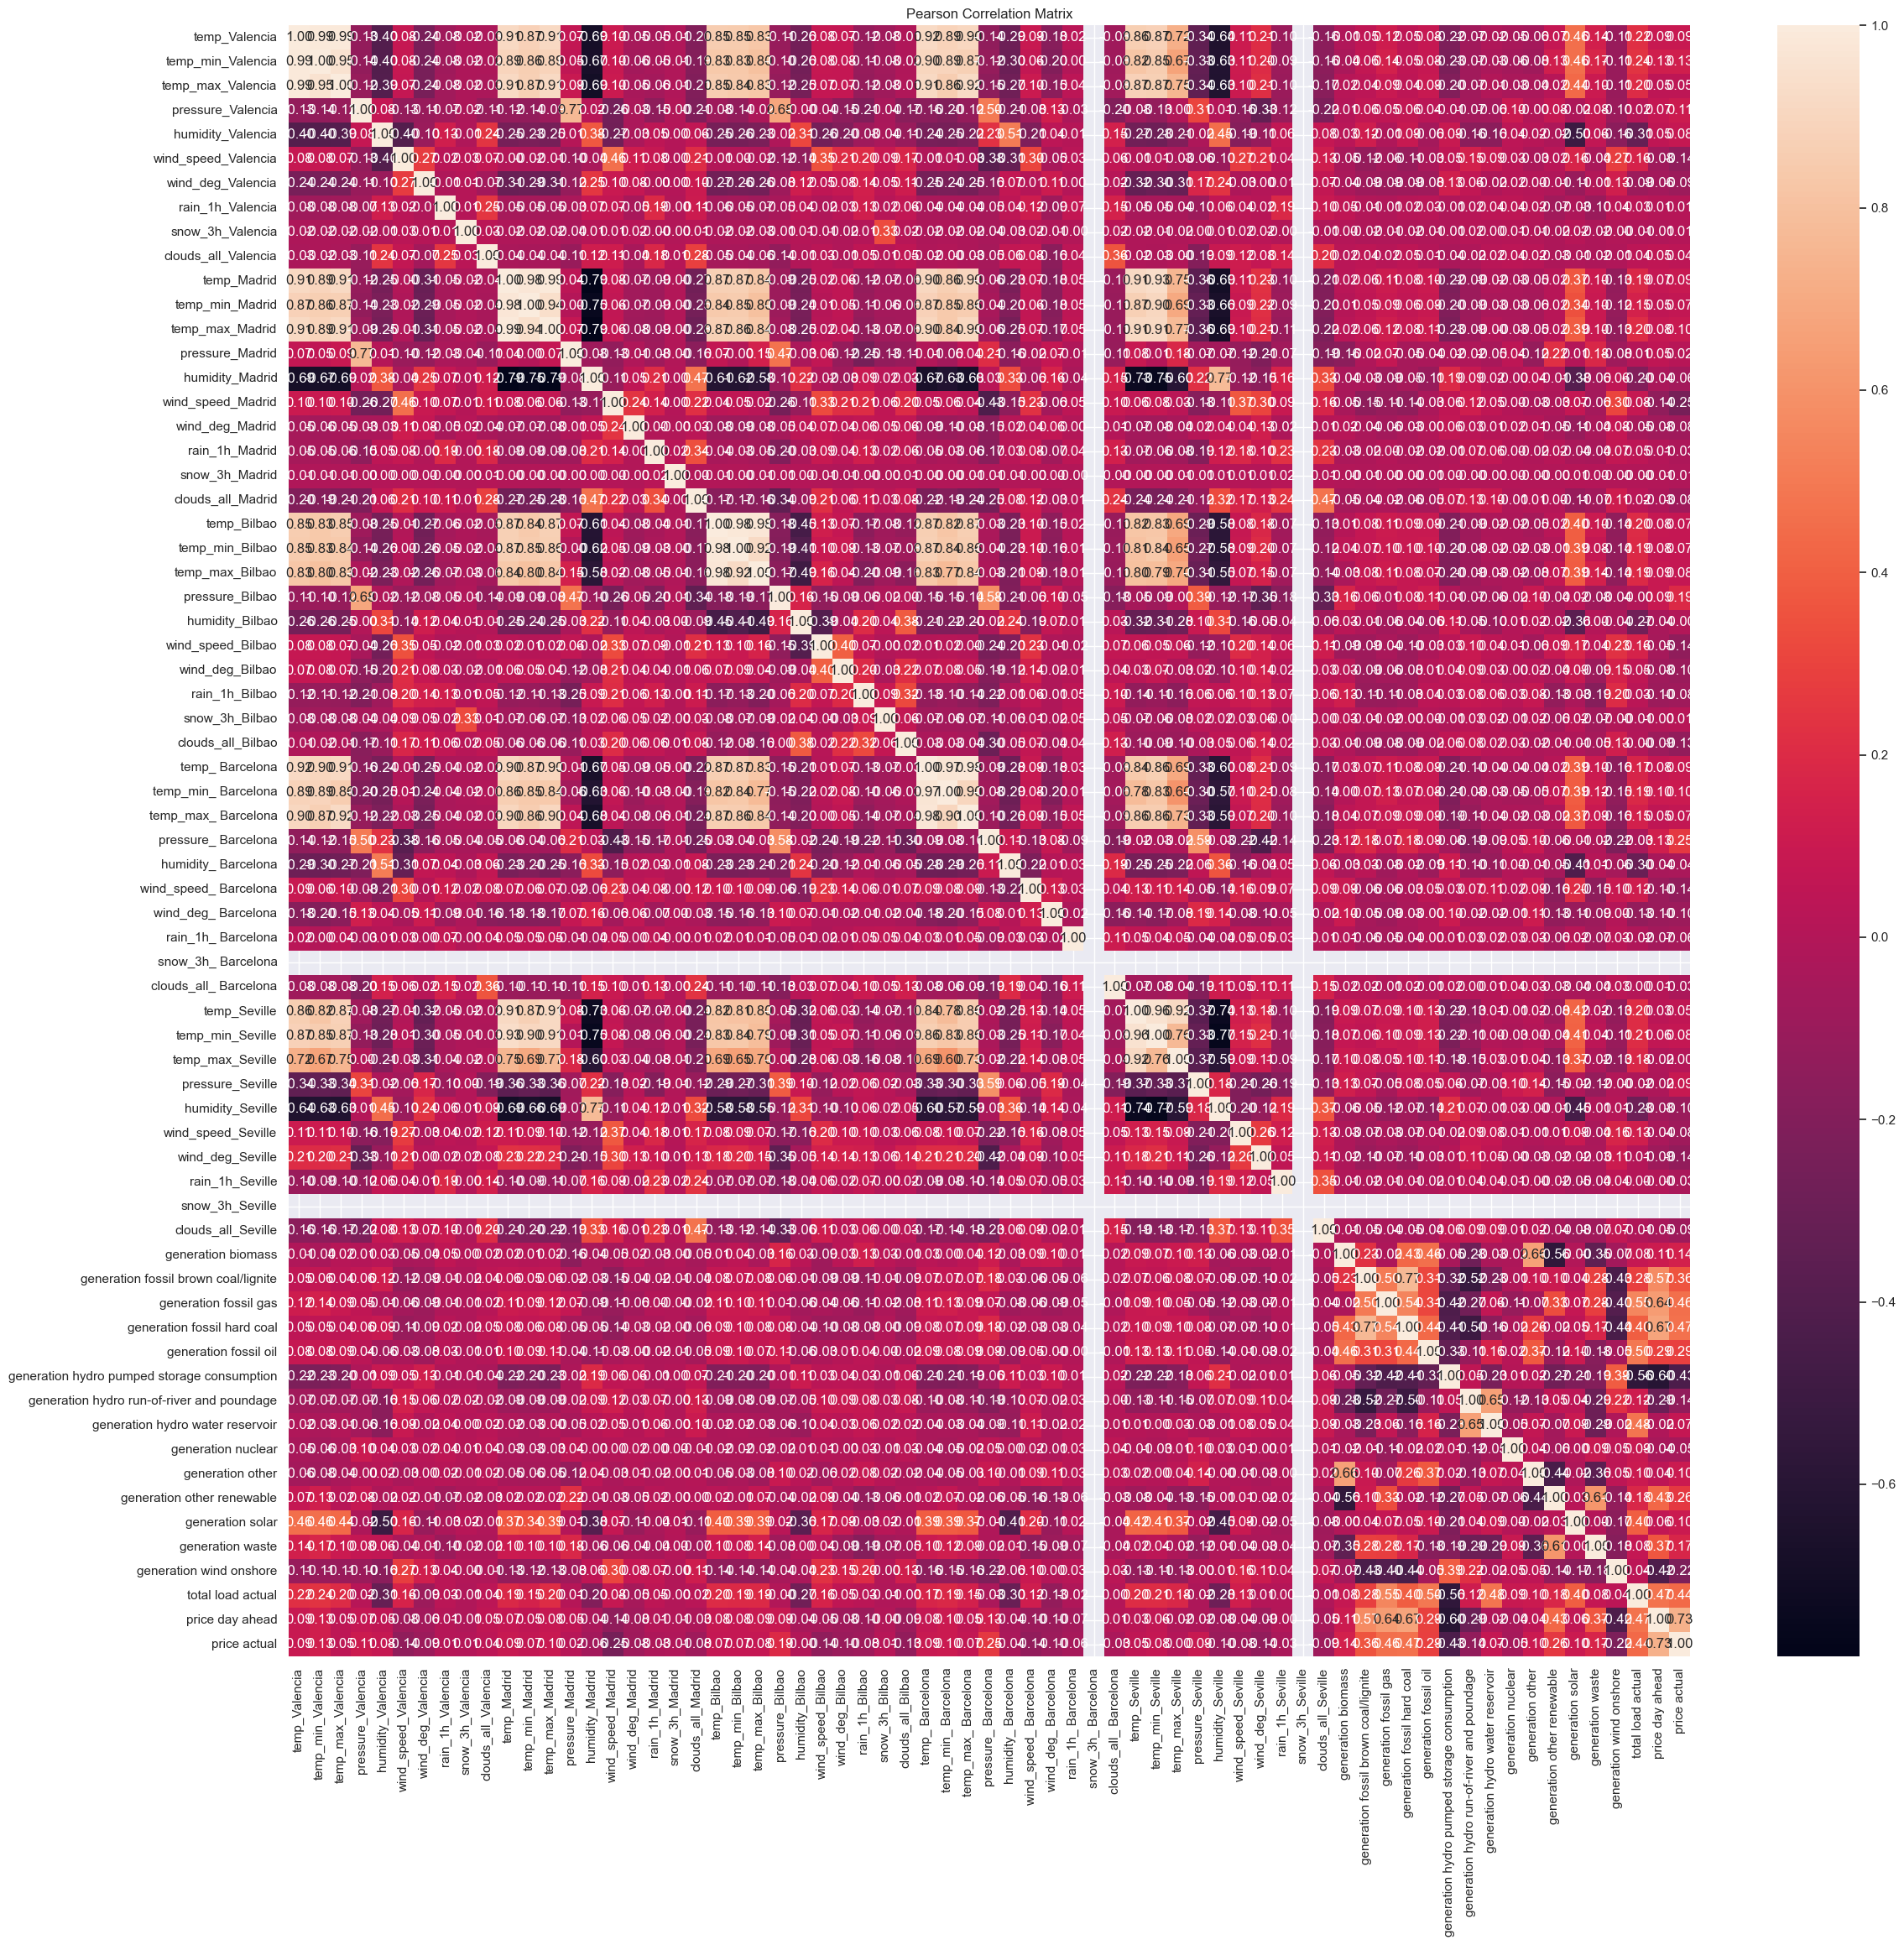

In [49]:
# Specifying catagorical columns to drop
columns_to_drop = [col for col in df_joined.columns if col.startswith('weather_description')]

# Drop the columns
df_joined_numerical = df_joined.drop(columns=columns_to_drop)

# Plot Pearson correlation matrix
correlations = df_joined_numerical.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

Interpreting meaningful patterns from this correlation matrix proves challenging; nevertheless, it is evident that several columns display substantial correlations. In order to delve deeper into insights related to ***price actual*** and ***total load actual***, our focus will shift to the features exhibiting the strongest correlations with these two variables.

In [50]:
# Find the correlations between the electricity price and the rest of the features
print("Top Correlations With Electricty Prices:\n")
print(correlations['price actual'].sort_values(ascending=False))

Top Correlations With Electricty Prices:

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
                                                 ...   
generation wind onshore                       -0.220497
wind_speed_Madrid                             -0.245861
generation hydro pumped storage consumption   -0.426196
snow_3h_ Barcelona                                  NaN
snow_3h_Seville                                     NaN
Name: price actual, Length: 67, dtype: float64


In [51]:
# Find the correlations between the load and the rest of the features

print("Top Feature Correlations With Load:\n")
print(correlations['total load actual'].sort_values(ascending=False))

Top Feature Correlations With Load:

total load actual                              1.000000
generation fossil gas                          0.548986
generation fossil oil                          0.496139
generation hydro water reservoir               0.479491
price day ahead                                0.474273
                                                 ...   
humidity_ Barcelona                           -0.300901
humidity_Valencia                             -0.314687
generation hydro pumped storage consumption   -0.562934
snow_3h_ Barcelona                                  NaN
snow_3h_Seville                                     NaN
Name: total load actual, Length: 67, dtype: float64


Apart from ***price actual*** and ***total load actual*** correlating with one another (with a value of ~0.44), we also observe that fossil fuel generation features appear to correlate with both of these features as well. Interestingly, we also find that ***generation hydro pumped storage consumption*** is most negatively correlated with both ***price actual*** and ***total load actual***

Another interesting observation emerges when considering ***price day ahead***, which exhibits the highest correlation with ***price actual***. It would be intriguing to investigate how machine learning predictions perform without this particular information in the future.

Furthermore, due to the lack of correlation between ***snow_3h_Barcelona*** and ***snow_3h_Seville*** with both price and load (implying improbable snowfall in these cities within our timeframe), we will exclude these columns from our analysis.

In [52]:
# Dropping columns
df_joined.drop(columns=['snow_3h_ Barcelona', 'snow_3h_Seville'], inplace=True)

# 3. Time Series Forecasting - Prophet

## 3.1 Load Forecasting

Facebook's Prophet proves advantageous in predicting electricity loads due to its capability to accommodate the intricate time series patterns inherent in electricity consumption. By employing additive modeling and Fourier decomposition, Prophet adeptly captures daily, weekly, and yearly seasonality in electricity load fluctuations, enhancing the accuracy of demand forecasts. The tool's automated outlier detection further enhances forecast precision by identifying irregular data points. Additionally, Prophet's capacity to quantify uncertainty intervals offers decision-makers a clear understanding of forecast reliability. 

It's important to note that the forecasting model described here solely relies on dates and their corresponding loads as inputs, omitting patterns related to generation, weather, or external conditions. While this omission could impact the model's performance, it still establishes a robust foundation for predicting electric loads and discerning trends.

In [53]:
# Getting load information from df_joined
prophet_df_load = df_joined.reset_index()[['time', 'total load actual']].rename(columns={'time': 'ds', 'total load actual': 'y'})

# Localizing time
prophet_df_load['ds'] = prophet_df_load['ds'].dt.tz_localize(None)

In [54]:
# Splitting into training and validation datasets
split_date = '2018-01-01'
prophet_load_train = prophet_df_load.loc[prophet_df_load.ds  < split_date].copy()
prophet_load_val = prophet_df_load.loc[prophet_df_load.ds  >= split_date].copy()

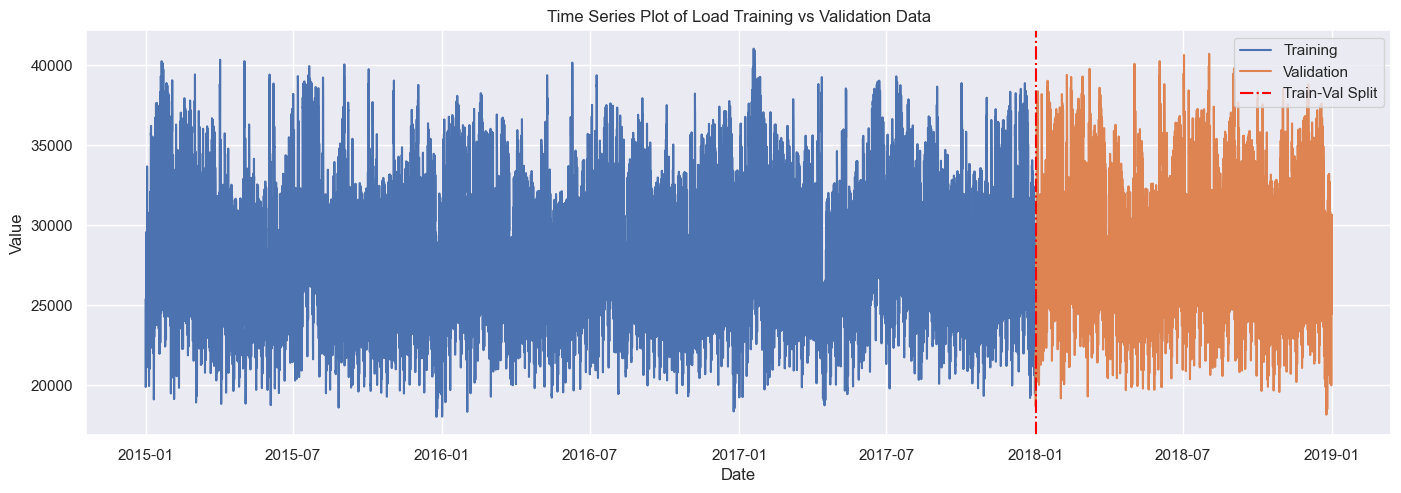

In [55]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Plot data
ax.plot(prophet_load_train.ds, prophet_load_train.y, label='Training', linestyle='-')
ax.plot(prophet_load_val.ds, prophet_load_val.y, label='Validation', linestyle='-')

# Highlight the split between training and validation with a vertical line
ax.axvline(pd.to_datetime(split_date), color='red', linestyle='-.', label='Train-Val Split')

# Add titles and labels
ax.set_title('Time Series Plot of Load Training vs Validation Data')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.show()


In [56]:
# Creating Prophet model with 95% confidence interval
m_load = Prophet(interval_width=0.95)

# Fitting model
m_load.fit(prophet_load_train)

# Using fitted model to create forecast
prophet_load_forecast = m_load.predict(df=prophet_load_val)

12:40:52 - cmdstanpy - INFO - Chain [1] start processing
12:41:05 - cmdstanpy - INFO - Chain [1] done processing


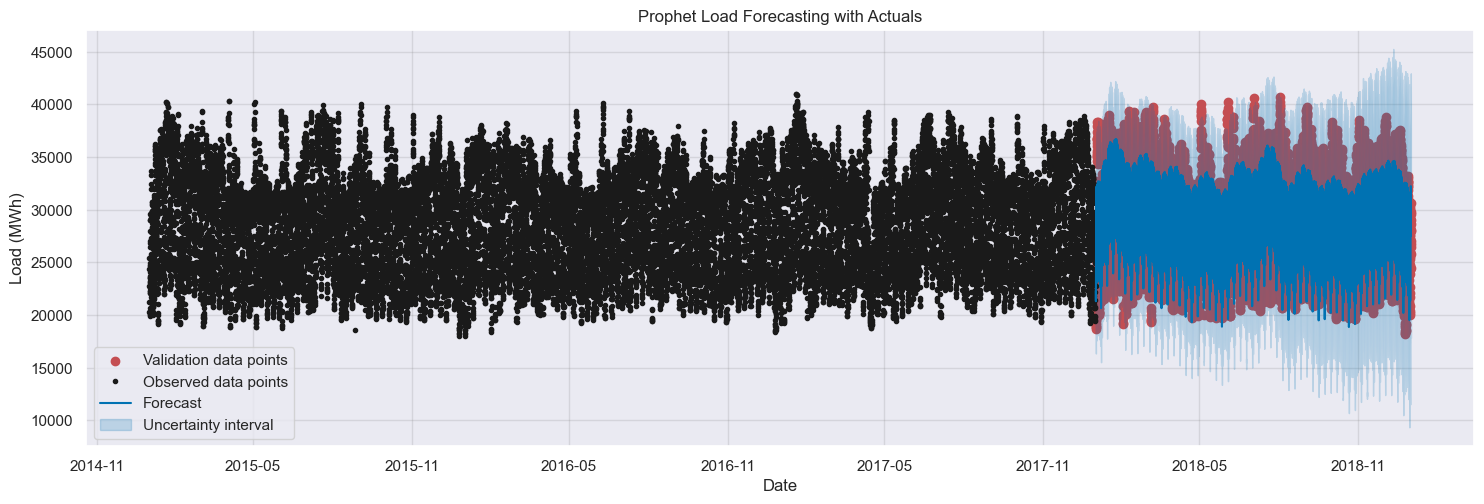

In [57]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_load_val.ds, prophet_load_val.y, color='r', label='Validation data points')
fig = m_load.plot(prophet_load_forecast, ax=ax)
ax.set_title('Prophet Load Forecasting with Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('Load (MWh)')
ax.legend()
plt.show()

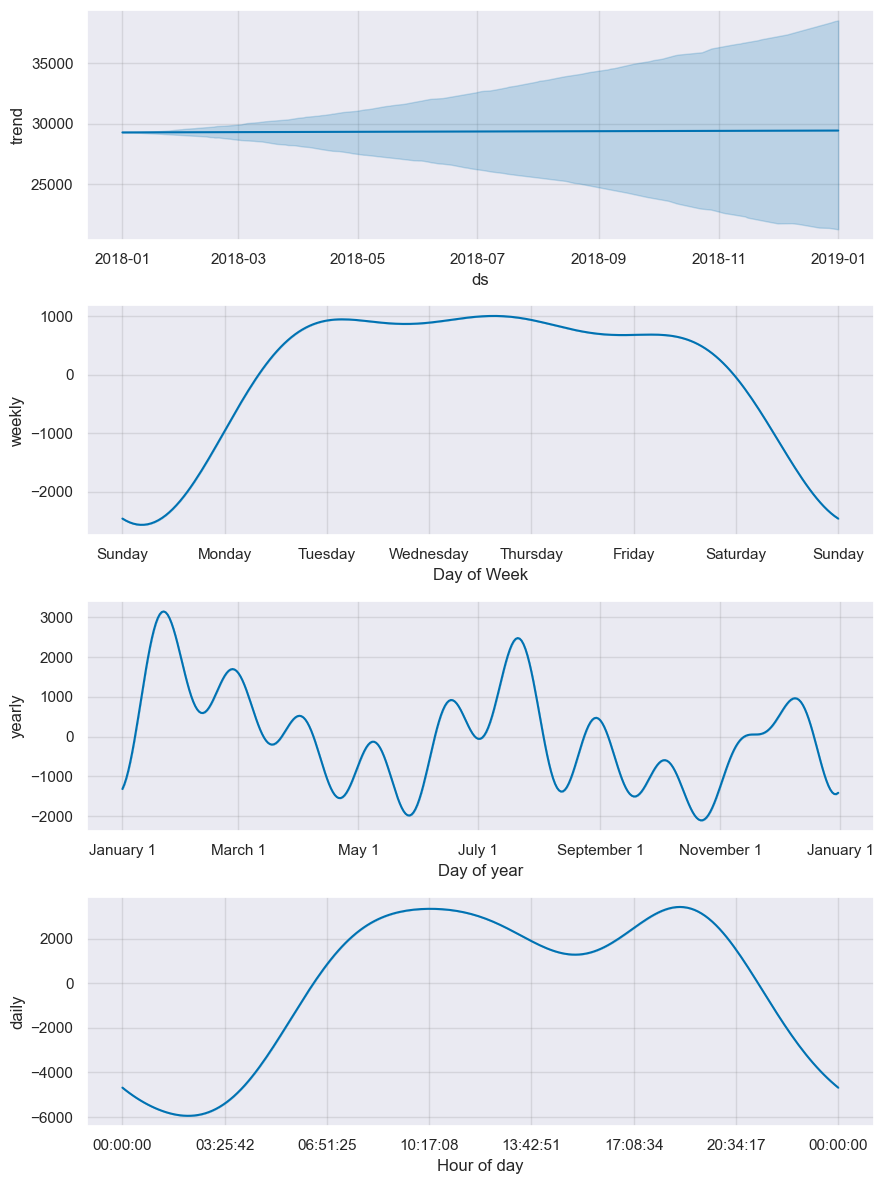

In [58]:
fig = m_load.plot_components(prophet_load_forecast)
plt.show()

Upon dissecting seasonal trends, several intriguing observations come to light. Initially, it becomes evident that the forecast maintains a relatively consistent pattern without any pronounced linear trend beneath it. Notably, there is a substantial reduction in electricity usage during weekends, aligning with expectations. Additionally, the peaks in electricity consumption during summer and winter stand out prominently.

Another interesting aspect of the component decomposition is the midday decline in load. Unlike many Western cultures, Spain incorporates a _siesta_, a break typically spanning from 2 pm to 5 pm, into its workday. This temporal frame closely corresponds to the dip evident in the component decomposition.

To gain a deeper understanding of the time series forecast, we will now delve into shorter forecasting intervals: one month and one week.

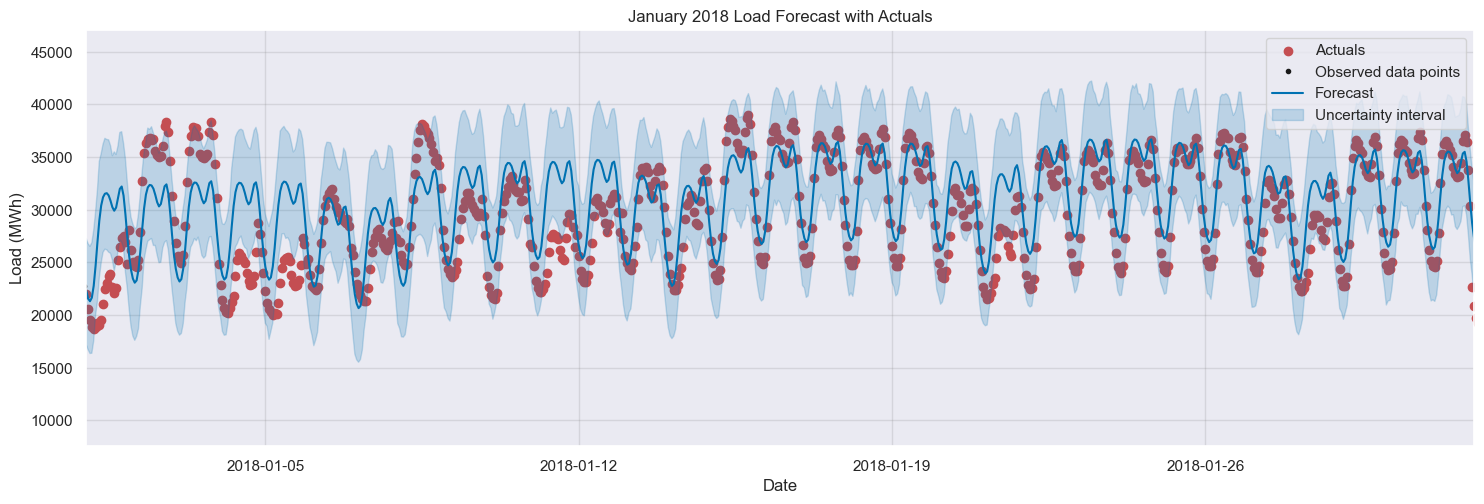

In [59]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_load_val.ds, prophet_load_val.y , color='r', label='Actuals')
fig = m_load.plot(prophet_load_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2018'),
              upper=pd.to_datetime('02-01-2018'))
ax.set_title('January 2018 Load Forecast with Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('Load (MWh)')
ax.legend()
plt.show()

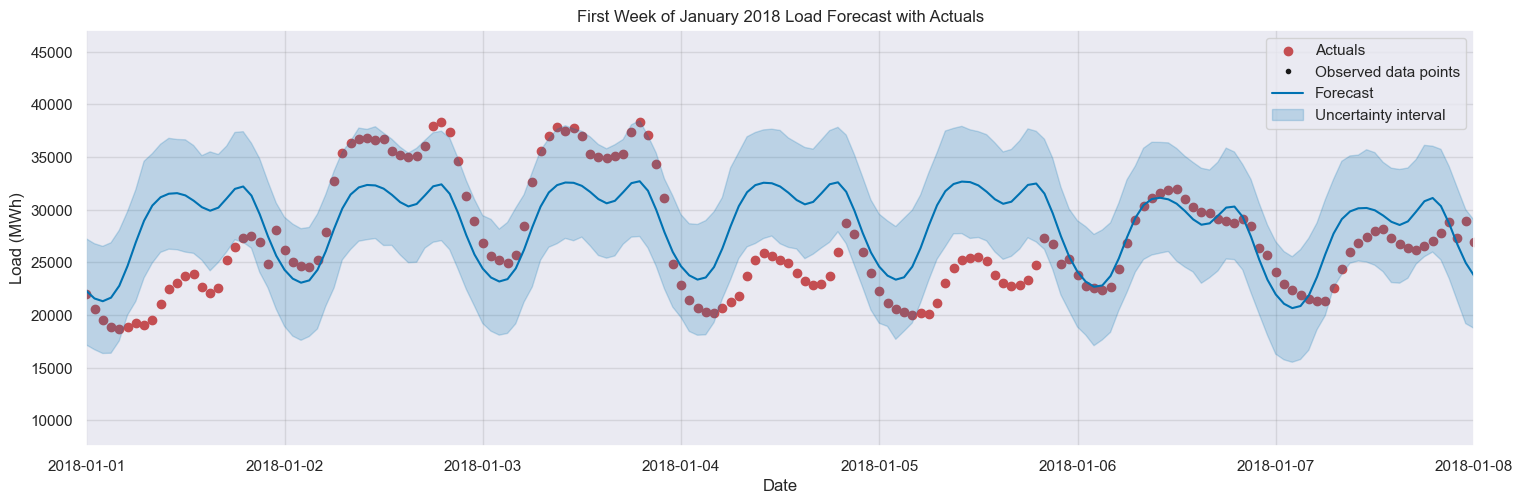

In [60]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_load_val.ds, prophet_load_val.y , color='r', label='Actuals')
fig = m_load.plot(prophet_load_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2018'),
              upper=pd.to_datetime('01-08-2018'))
ax.set_title('First Week of January 2018 Load Forecast with Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('Load (MWh)')
ax.legend()
plt.show()

### 3.1.1 Error Metrics

In [61]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [62]:
prophet_load_rmse = mean_squared_error(y_true=prophet_load_val.y,
                                      y_pred=prophet_load_forecast.yhat,
                                      squared=False)

propher_load_mae = mean_absolute_error(y_true=prophet_load_val.y,
                                 y_pred=prophet_load_forecast.yhat)

prophet_load_mape = mean_absolute_percentage_error(y_true=prophet_load_val.y,
                                                  y_pred=prophet_load_forecast.yhat)


print(f'The RMSE is: {prophet_load_rmse:.2f}')
print(f'The MAE is: {propher_load_mae:.2f}')
print(f"The MAPE is: {prophet_load_mape:.2f}%")

The RMSE is: 2779.74
The MAE is: 2103.00
The MAPE is: 7.42%


Analyzing the error metrics, we note a relatively modest ***mean absolute percentage error*** of $7.42\%$. This outcome underscores the proficiency of our Prophet model as an effective electric load predictor. This aligns with our earlier observations regarding the behavior of the ***total load*** time series. Thanks to the robust seasonal patterns of ***total load***, Prophet demonstrates the capability to yield precise predictions using historical data.

## 3.2 Price Forecasting

We now dive into price forecasting using Prophet. Observing the time series trends associated with price, we see that it is much more sporadic than load and has less obvious seasonality associated with it. This is likely due to external data which we do not have available, such as fuel prices. That being said, we will look into forecasting price using Prophet to observe some of these seasonal trends.

In [63]:
# Getting load information from df_joined
prophet_df_price = df_joined.reset_index()[['time', 'price actual']].rename(columns={'time': 'ds', 'price actual': 'y'})

# Localizing time
prophet_df_price['ds'] = prophet_df_price['ds'].dt.tz_localize(None)

In [64]:
# Splitting into training and validation datasets
split_date = '2018-01-01'
prophet_price_train = prophet_df_price.loc[prophet_df_price.ds < split_date].copy()
prophet_price_val = prophet_df_price.loc[prophet_df_price.ds >= split_date].copy()

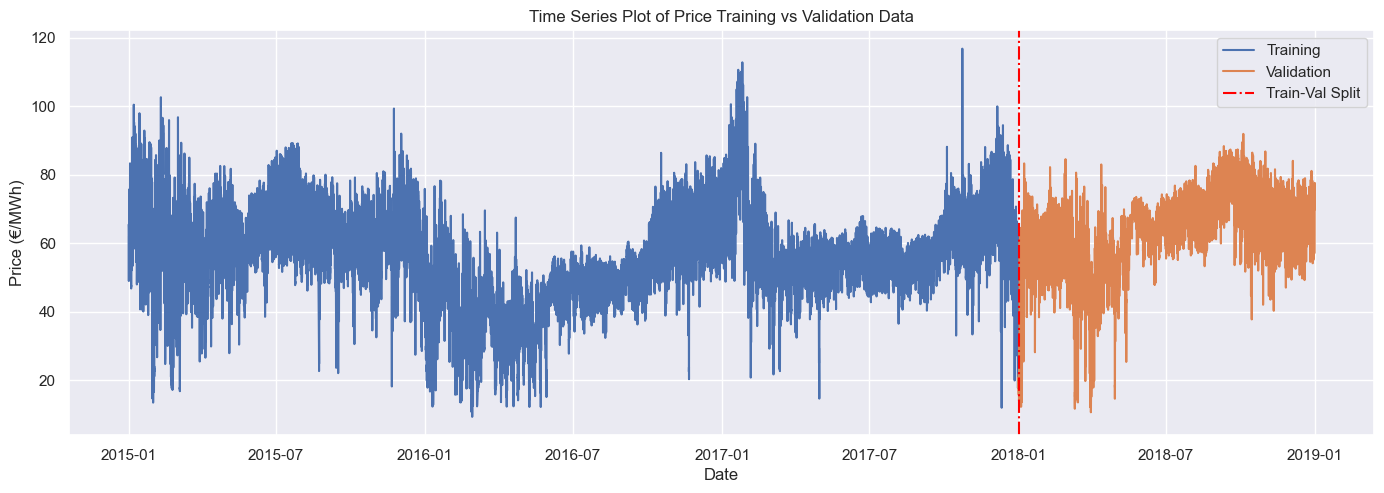

In [65]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 5))  # Adjust the size as needed

# Plot data
ax.plot(prophet_price_train.ds, prophet_price_train.y, label='Training', linestyle='-')
ax.plot(prophet_price_val.ds, prophet_price_val.y, label='Validation', linestyle='-')

# Highlight the split between training and validation with a vertical line
ax.axvline(pd.to_datetime(split_date), color='red', linestyle='-.', label='Train-Val Split')

# Add titles and labels
ax.set_title('Time Series Plot of Price Training vs Validation Data')
ax.set_xlabel('Date')
ax.set_ylabel('Price (€/MWh)')
ax.legend()
plt.show()

In [66]:
# Creating Prophet model with 95% confidence interval
m_price = Prophet(interval_width=0.95)

# Fitting model
m_price.fit(prophet_price_train)

# Using fitted model to create forecast
prophet_price_forecast = m_price.predict(df=prophet_load_val)

12:41:16 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing


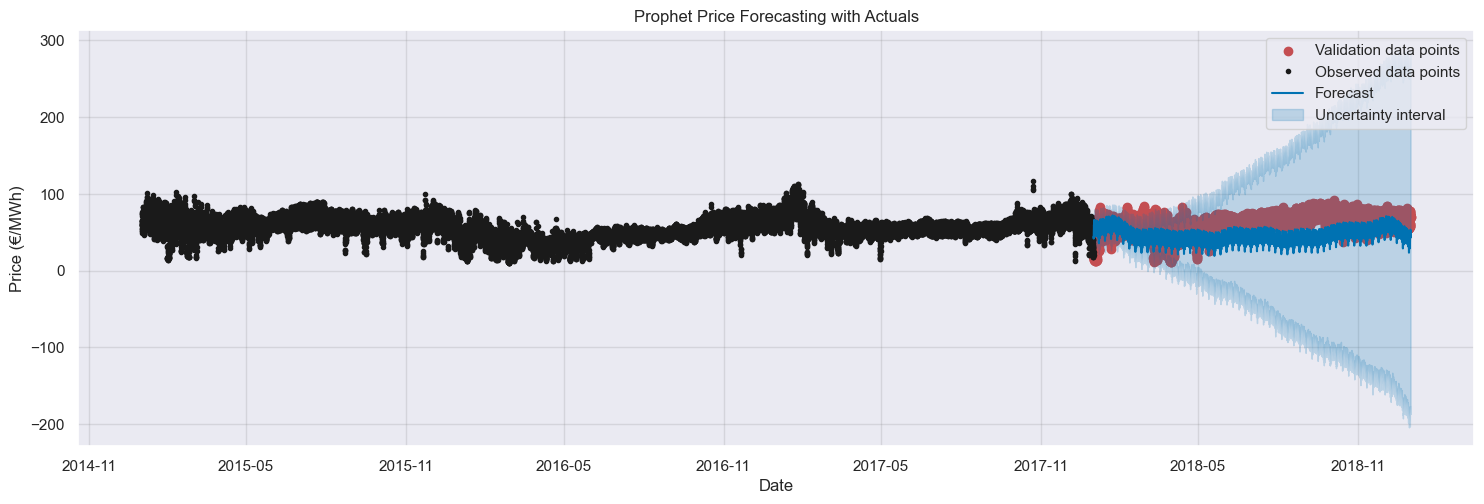

In [67]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_price_val.ds, prophet_price_val.y, color='r', label='Validation data points')
fig = m_price.plot(prophet_price_forecast, ax=ax)
ax.set_title('Prophet Price Forecasting with Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('Price (€/MWh)')
ax.legend()
plt.show()

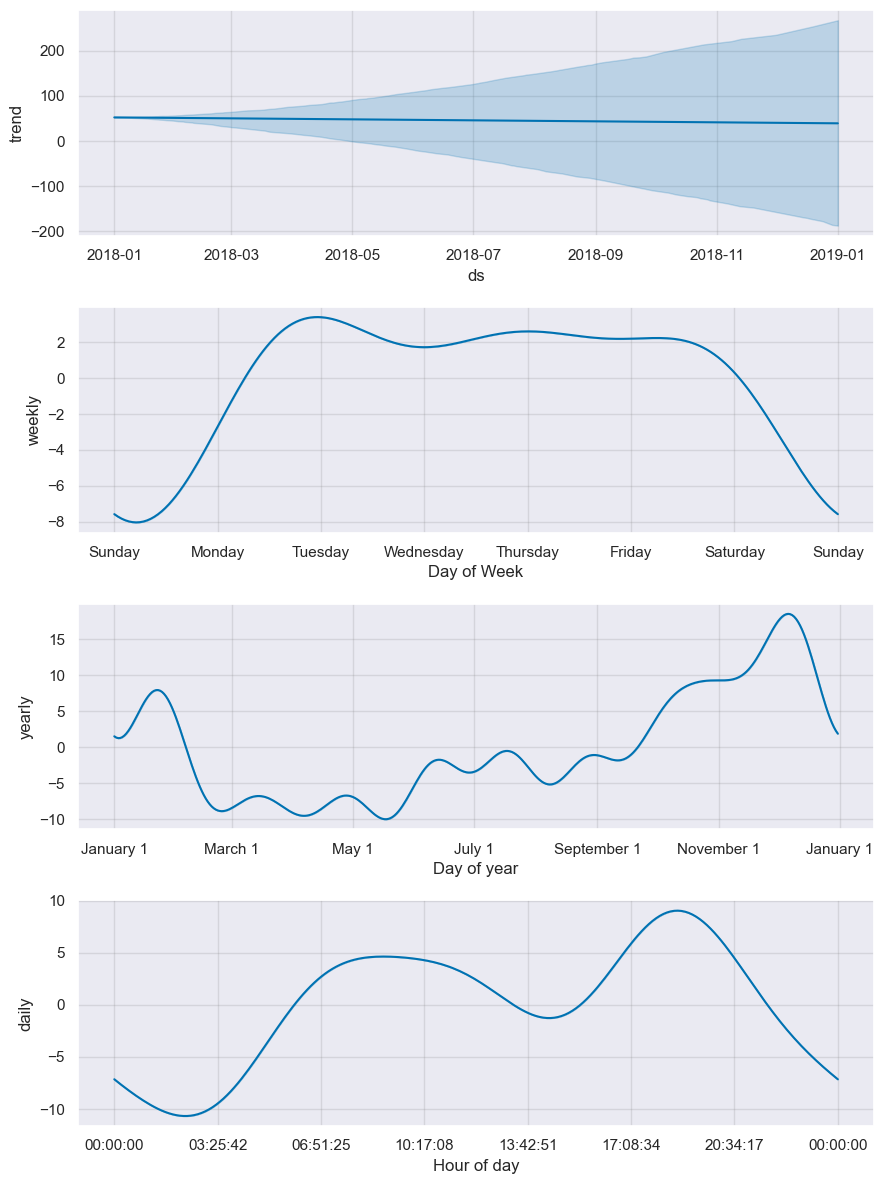

In [68]:
fig = m_price.plot_components(prophet_price_forecast)
plt.show()

When examining the seasonality of ***price actual***, similar trends to those in ***total load actual*** become evident. However, a noteworthy distinction arises: the summer peak in ***price actual*** is significantly less pronounced. Instead, the primary peak in price occurs during the late fall to early winter period, while remaining relatively stable throughout the rest of the year.

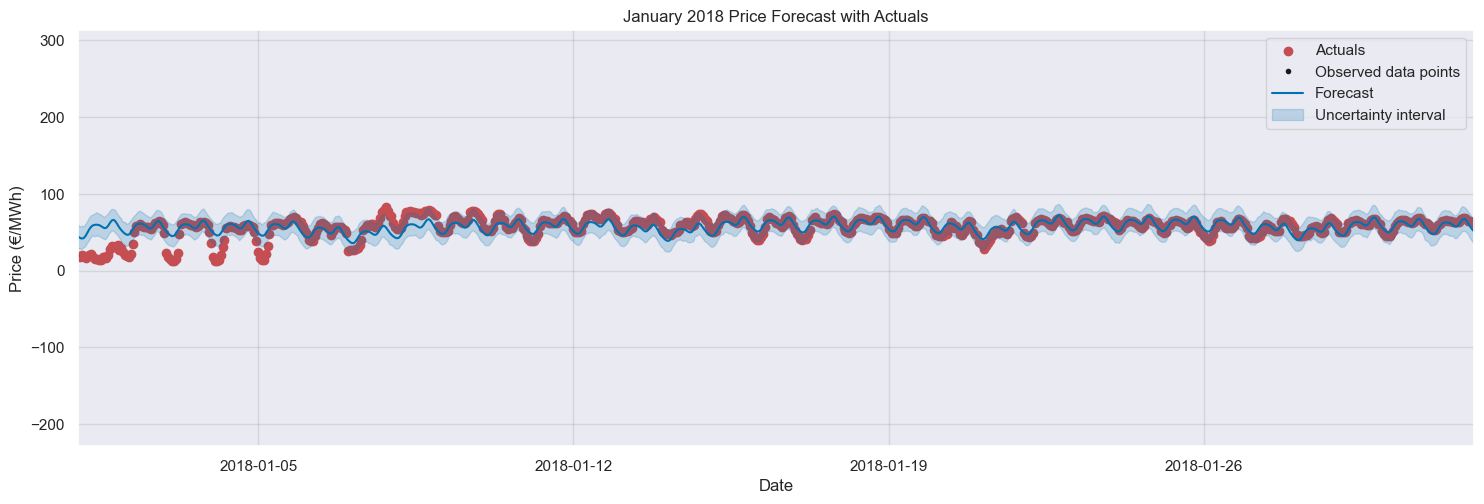

In [69]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_price_val.ds, prophet_price_val.y , color='r', label='Actuals')
fig = m_price.plot(prophet_price_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2018'),
              upper=pd.to_datetime('02-01-2018'))
ax.set_title('January 2018 Price Forecast with Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('Price (€/MWh)')
ax.legend()
plt.show()

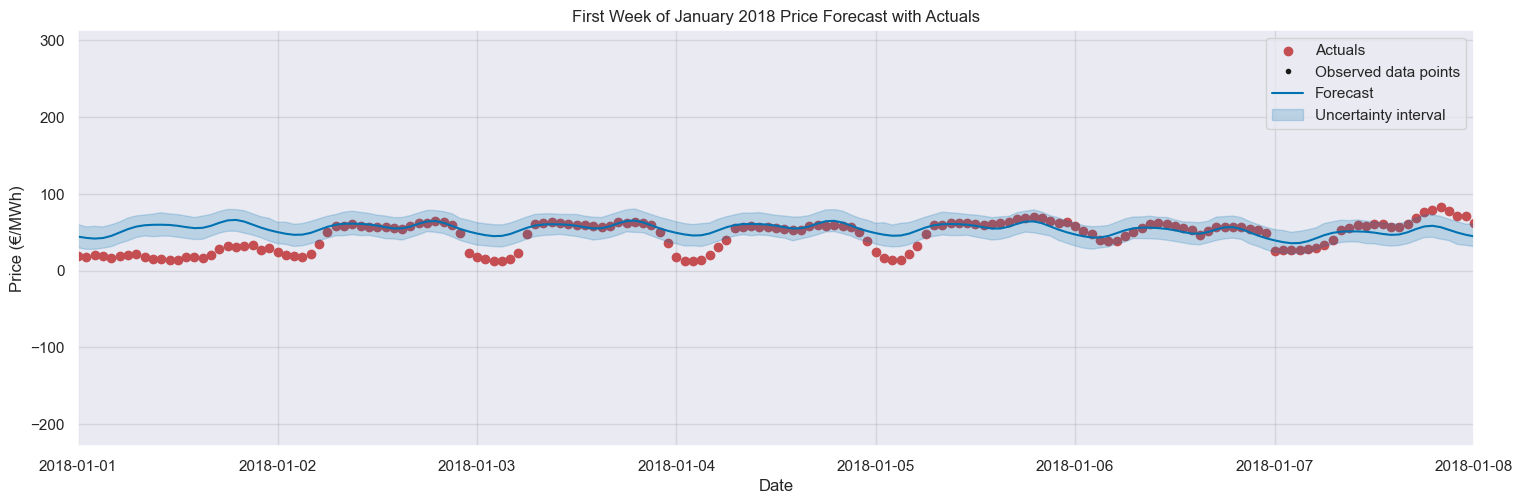

In [70]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_price_val.ds, prophet_price_val.y , color='r', label = 'Actuals')
fig = m_price.plot(prophet_price_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2018'),
              upper=pd.to_datetime('01-08-2018'))
ax.set_title('First Week of January 2018 Price Forecast with Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('Price (€/MWh)')
ax.legend()
plt.show()

### 3.2.1 Error Metrics

In [71]:
prophet_price_rmse = mean_squared_error(y_true=prophet_price_val.y,
                                        y_pred=prophet_price_forecast.yhat,
                                        squared=False)

prophet_price_mae = mean_absolute_error(y_true=prophet_price_val.y,
                                        y_pred=prophet_price_forecast.yhat)

prophet_price_mape = mean_absolute_percentage_error(y_true=prophet_price_val.y,
                                                    y_pred=prophet_price_forecast.yhat)

print(f'The RMSE is: {prophet_price_rmse:.2f}')
print(f'The MAE is: {prophet_price_mae:.2f}')
print(f"The RMSE is: {prophet_price_mape:.2f}%")

The RMSE is: 21.44
The MAE is: 18.86
The RMSE is: 30.26%


Upon reviewing the error metrics, it becomes evident that the ***mean absolute percentage error*** for price forecasting is notably higher, standing at $30.26\%$. This outcome underscores that our Prophet model's predictive performance is less consistent for price compared to load. This underscores the requirement for more sophisticated forecasting approaches that incorporate additional explanatory variables.

# 4. Feature Engineering

## 4.1 Feature Creation

To initiate our feature creation process, we will generate attributes derived from our time index. Many machine learning models, such as XGBoost and neural networks, lack the innate capability to directly interpret time indices. Consequently, we need to construct distinct features based on the datetime index. This transformation is essential to enable our model to discern and learn from temporal patterns.

In [72]:
# Creating new dataframe
df_final_unencoded = df_joined.copy()

# Creating temporal features
df_final_unencoded['hour'] = df_final_unencoded.index.hour
df_final_unencoded['day_of_week'] = df_final_unencoded.index.weekday
df_final_unencoded['day_of_month'] = df_final_unencoded.index.day
df_final_unencoded['quarter'] = df_final_unencoded.index.quarter
df_final_unencoded['month'] = df_final_unencoded.index.month
df_final_unencoded['year'] = df_final_unencoded.index.year

As visible in the prophet forecasting decomposition of ***price actual***, we see a noticable dip in electricity prices over the weekend. Therefor, we will create an explicit feature to define whether or not our sample is on a weekend or not.

In [73]:
df_final_unencoded['weekday'] = (df_final_unencoded['day_of_week'] < 5).astype(int)

Moreover, we aim to incorporate specific details about the population of each city into our analysis. To accomplish this, we intend to introduce a new column called the ***weighted_load*** for every city. This column will be generated by computing the population-based weight for each city and then multiplying this weight by the load registered at a given moment. By doing so, we will obtain a feature that provides an approximation of the energy consumption for each city. This approach operates under the assumption of uniform per capita power consumption across all cities.

In [74]:
city_pop = {'Madrid': 6155116,
            'Barcelona': 5179243,
            'Valencia': 1645342,
            'Seville': 1305342,
            'Bilbao': 987000}

In [75]:
total_pop = sum(city_pop.values())
city_weights = {c: w/total_pop for c, w in city_pop.items()}

for city, population in city_weights.items():
    df_final_unencoded[city + '_weighted_load'] = df_final_unencoded['total load actual'] * population

## 4.2 Encoding

Finally, we apply one-hot encoding to all categorical variables. Given that these variables share the common prefix ***weather_description***, we capitalize on this characteristic to guide our encoding segmentation.

In [76]:
# Identify columns starting with 'weather_description'
weather_description_cols = [col for col in df_final_unencoded.columns if col.startswith('weather_description')]

# Apply one-hot encoding to the identified columns
df_final_encoded = pd.get_dummies(df_final_unencoded, columns=weather_description_cols, prefix=weather_description_cols)

In [77]:
len(df_final_encoded.columns)

225

## 4.3 Feature Selection

The dataframe containing encoded categorical variables exhibits substantial dimensionality, boasting a total of 227 features. The process of training models on this particular dataset might pose a significant computational burden due to its extensive nature. To alleviate this computational load, it becomes necessary to trim redundant features.

Given that our dataset encompasses a mix of both numerical and boolean features, the application of conventional dimensionality reduction approaches like PCA presents challenges. Consequently, we are compelled to adopt an alternative strategy. Specifically, we will assess the mutual information between each feature and the target variable.

In [78]:
target = 'price actual'

# Separate features and target
X = df_final_encoded.drop(target, axis=1)
y = df_final_encoded[target]

# Calculate mutual information for numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64', 'int32'])
mi_numerical = mutual_info_regression(X[numerical_features.columns], y)

# Calculate mutual information for boolean features (treated as categorical)
boolean_features = X.select_dtypes(include=['bool'])
mi_boolean = mutual_info_regression(X[boolean_features.columns].astype(int), y)

# Create DataFrames to hold feature names and MI scores
mi_numerical_df = pd.DataFrame({'Feature': numerical_features.columns, 'MI_Score': mi_numerical})
mi_boolean_df = pd.DataFrame({'Feature': boolean_features.columns, 'MI_Score': mi_boolean})

# Sort DataFrames by MI scores
sorted_mi_numerical = mi_numerical_df.sort_values(by='MI_Score', ascending=False)
sorted_mi_boolean = mi_boolean_df.sort_values(by='MI_Score', ascending=False)

In [79]:
# Print sorted feature names and MI scores
print("Sorted Numerical Features and MI Scores:")
print(sorted_mi_numerical)

print("\nSorted Boolean Features and MI Scores:")
print(sorted_mi_boolean)

Sorted Numerical Features and MI Scores:
                        Feature  MI_Score
63              price day ahead  0.846280
50        generation fossil gas  0.207621
51  generation fossil hard coal  0.181770
68                        month  0.163251
69                         year  0.158480
..                          ...       ...
7              rain_1h_Valencia  0.001579
18               snow_3h_Madrid  0.001529
46              rain_1h_Seville  0.001204
17               rain_1h_Madrid  0.000368
8              snow_3h_Valencia  0.000000

[76 rows x 2 columns]

Sorted Boolean Features and MI Scores:
                                               Feature  MI_Score
47             weather_description_Madrid_sky is clear  0.013080
80             weather_description_Bilbao_sky is clear  0.009328
57                      weather_description_Bilbao_fog  0.006938
141           weather_description_Seville_sky is clear  0.006062
24            weather_description_Madrid_broken clouds  0.005354
..

Examining the mutual information between our features and target (***price_actual***), we can clearly see that the numerical features have a lot more mutual information with ***price_actual*** than the boolean features. Hwever, when deciding which features to drop, we also must consider that ML models such as XGBoost can deal with boolean features more easily than numerical ones. Because of this, we will have different criteria for dropping boolean and numerical features. The criteria for dropping boolean features will be much more lenient.

Regaring our numeric features, we will drop features which reside in the bottom quartile of mutual information. For our boolean features, we will drop anything with less mutual information than $0.001$. While this value is somewhat arbitrary, the criteria for boolean features was chosen based on the fact that any mutual values below this will likely not contribute the model in any significant capacity to. 

In [80]:
# Calculate the 25th quartile
quartile_25 = mi_numerical_df['MI_Score'].quantile(0.25)

# Picking features based on afformentioned criteria
important_numerical_features = mi_numerical_df[mi_numerical_df['MI_Score'] >= quartile_25]['Feature'].values
important_boolean_features = mi_boolean_df[mi_boolean_df['MI_Score'] >= 0.001]['Feature'].values

In [81]:
all_important_features = np.concatenate((important_numerical_features, important_boolean_features, np.array([target])))

Note the addition of the  target back into important features. Because we will be using time series data, the past target values will be used to predict future ones. This will be eloborated more in the windowing section. We now subset our data based on important columns.

In [82]:
df_final = df_final_encoded[all_important_features]
df_final.head()

temp_Valencia  temp_min_Valencia  \
time                                                          
2014-12-31 23:00:00+00:00        270.475            270.475   
2015-01-01 00:00:00+00:00        270.475            270.475   
2015-01-01 01:00:00+00:00        269.686            269.686   
2015-01-01 02:00:00+00:00        269.686            269.686   
2015-01-01 03:00:00+00:00        269.686            269.686   

                           temp_max_Valencia  pressure_Valencia  \
time                                                              
2014-12-31 23:00:00+00:00            270.475             1001.0   
2015-01-01 00:00:00+00:00            270.475             1001.0   
2015-01-01 01:00:00+00:00            269.686             1002.0   
2015-01-01 02:00:00+00:00            269.686             1002.0   
2015-01-01 03:00:00+00:00            269.686             1002.0   

                           humidity_Valencia  wind_speed_Valencia  \
time                                                                
2014-12-31 23:00:00+00:00                 77                  1.0   
2015-01-01 00:00:00+00:00                 77                  1.0   
2015-01-01 01:00:00+00:00                 78                  0.0   
2015-01-01 02:00:00+00:00                 78                  0.0   
2015-01-01 03:00:00+00:00                 78                  0.0   

                           wind_deg_Valencia  temp_Madrid  temp_min_Madrid  \
time                                                                         
2014-12-31 23:00:00+00:00                 62      267.325          267.325   
2015-01-01 00:00:00+00:00                 62      267.325          267.325   
2015-01-01 01:00:00+00:00                 23      266.186          266.186   
2015-01-01 02:00:00+00:00                 23      266.186          266.186   
2015-01-01 03:00:00+00:00                 23      266.186          266.186   

                           temp_max_Madrid  pressure_Madrid  humidity_Madrid  \
time                                                                           
2014-12-31 23:00:00+00:00          267.325            971.0               63   
2015-01-01 00:00:00+00:00          267.325            971.0               63   
2015-01-01 01:00:00+00:00          266.186            971.0               64   
2015-01-01 02:00:00+00:00          266.186            971.0               64   
2015-01-01 03:00:00+00:00          266.186            971.0               64   

                           wind_speed_Madrid  wind_deg_Madrid  \
time                                                            
2014-12-31 23:00:00+00:00                1.0              309   
2015-01-01 00:00:00+00:00                1.0              309   
2015-01-01 01:00:00+00:00                1.0              273   
2015-01-01 02:00:00+00:00                1.0              273   
2015-01-01 03:00:00+00:00                1.0              273   

                           clouds_all_Madrid  temp_Bilbao  temp_min_Bilbao  \
time                                                                         
2014-12-31 23:00:00+00:00                  0   269.657312       269.657312   
2015-01-01 00:00:00+00:00                  0   269.763500       269.763500   
2015-01-01 01:00:00+00:00                  0   269.251688       269.251688   
2015-01-01 02:00:00+00:00                  0   269.203344       269.203344   
2015-01-01 03:00:00+00:00                  0   269.485500       269.485500   

                           temp_max_Bilbao  pressure_Bilbao  wind_deg_Bilbao  \
time                                                                           
2014-12-31 23:00:00+00:00       269.657312           1036.0              226   
2015-01-01 00:00:00+00:00       269.763500           1035.0              229   
2015-01-01 01:00:00+00:00       269.251688           1036.0              224   
2015-01-01 02:00:00+00:00       269.203344           1035.0              225   
2015-01-01 03:00:00+00:00       269.4855

In [83]:
df_final.shape

(35064, 117)

Our feature selection efforts have allowed us to reduce the datas features from 227 to 115. We will now examine the performance of ML models trained on this data.

# 5. ML Price Forecasting

## 5.1 Preprocessing

We now get into the heart of our challenge: harnessing machine learning to predict electricity prices. Our initial focus rests on XGBoost, a potent model allowing us to predict hour-ahead prices based on the preceding 24 hours. To materialize this, we lay the foundation by devising a windowing function. This function dissects our data into smaller, time-indexed fragments, akin to what's illustrated in the image below.

  ![One prediction 24 hours into the future.](images/split_window.png)


In [84]:
def window_generator(dataframe, target_column, window_size, target_len=1, gap=0):
    """
    Generate window sequences from a given dataframe.

    Args:
        dataframe (pandas.DataFrame): The input dataframe containing the data.
        target_column (str): The name of the target column to predict.
        window_size (int): Size of the input window for each sequence.
        target_len (int, optional): Length of the target sequence. Default is 1.
        gap (int, optional): Gap between the end of the input window and the start of the target sequence. Default is 0.

    Returns:
        tuple: A tuple containing two numpy arrays:
            - The input data sequences of shape (num_sequences, window_size, num_features).
            - The corresponding target sequences of shape (num_sequences, target_len).
    """
    # Check if the total window length is within the bounds of the dataframe
    if window_size + target_len + gap > len(dataframe):
        print("Warning: Total window length is too long")
        return None, None
    
    data = []  # List to store input data sequences
    labels = []  # List to store target sequences

    start_index = window_size
    end_index = len(dataframe) - target_len - gap + 1
    
    # Generate sequences
    for i in range(start_index, end_index):
        indices = range(i - window_size, i)
        data.append(dataframe.iloc[indices].values)
        
        # Extract the target sequence based on the specified target length and gap
        labels.append(dataframe[target_column].iloc[i + gap : i + target_len + gap].values)

    return np.array(data), np.array(labels)

Prior to creating windows from our data, a preliminary step involves splitting and standardizing it. After segmenting the data into training, validation, and testing subsets, standardization is applied. 

This process starts by segregating columns into boolean and non-boolean categories. For boolean data, standardization is omitted. Subsequently, distinct standardization instances are fashioned for both features and targets. This distinction aids in the inverse transformation of data when dealing with predicted outcomes.

In [85]:
# Splitting into training, validation and testing sets
n = len(df_final)
df_train = df_final[0:int(n*0.7)].copy()
df_val = df_final[int(n*0.7):int(n*0.9)].copy()
df_test = df_final[int(n*0.9):].copy()

In [86]:
# Getting numerical columns excluding boolean columns and target column
non_boolean_cols = df_train.select_dtypes(exclude=['bool']).columns
target_col = 'price actual'

# Remove the target column from the list of non-boolean columns
non_boolean_cols = non_boolean_cols.drop(target_col)

# Compute normalization parameters on training data for non-boolean columns
scaler_x = StandardScaler()
scaler_x.fit(df_train[non_boolean_cols])

# Apply the same parameters to training, validation, and testing data for non-boolean columns
df_train.loc[:, non_boolean_cols] = scaler_x.transform(df_train[non_boolean_cols])
df_val.loc[:, non_boolean_cols] = scaler_x.transform(df_val[non_boolean_cols])
df_test.loc[:, non_boolean_cols] = scaler_x.transform(df_test[non_boolean_cols])

# For the target column, compute normalization parameters and scale separately
scaler_y = StandardScaler()
scaler_y.fit(df_train[[target_col]])

# Apply the same parameters to training, validation, and testing data for the target column
df_train.loc[:, [target_col]] = scaler_y.transform(df_train[[target_col]])
df_val.loc[:, [target_col]] = scaler_y.transform(df_val[[target_col]])
df_test.loc[:, [target_col]] = scaler_y.transform(df_test[[target_col]])

In [87]:
# Windowing parameters
window_size_xgb_1h = 24
target_len_xgb_1h = 1
gap_xgb_1h = 0

# Training window size used for plotting
tot_window_size_xgb_1h = window_size_xgb_1h + gap_xgb_1h

In [88]:
# Generating windows
X_train_1h, y_train_1h = window_generator(dataframe=df_train, target_column='price actual',
                                          window_size=window_size_xgb_1h, target_len=target_len_xgb_1h, gap=gap_xgb_1h)

X_val_1h, y_val_1h = window_generator(dataframe=df_val, target_column='price actual', 
                                      window_size=window_size_xgb_1h, target_len=target_len_xgb_1h, gap=gap_xgb_1h)

X_test_1h, y_test_1h = window_generator(dataframe=df_test, target_column='price actual', 
                                        window_size=window_size_xgb_1h, target_len=target_len_xgb_1h, gap=gap_xgb_1h)

In [89]:
# Flatten input sequences
X_train_flat_1h = X_train_1h.reshape(X_train_1h.shape[0], -1)
X_val_flat_1h = X_val_1h.reshape(X_val_1h.shape[0], -1)
X_test_flat_1h = X_test_1h.reshape(X_test_1h.shape[0], -1)

## 5.2 XGBoost - Hour Ahead

With our input data processed, we begin formulating our XGBoost model. We begin by using Optuna to optimize XGBoost's hyperparameters.

In [127]:
# Define the objective function
def objective(trial):
    params = {
        'objective': 'reg:squarederror',  # Regression task
        'eval_metric': 'rmse',            # Evaluation metric
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 5, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'alpha': trial.suggest_float('alpha', 0.01, 5),
        'lambda': trial.suggest_float('lambda', 0.01, 5),
        'gamma': trial.suggest_float('gamma', 0.01, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10.0),
        'n_jobs': -1
    }
    
    # Train XGBoost model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_flat_1h, y_train_1h)
    
    # Make predictions and calculate validation error
    y_pred_1h = model.predict(X_val_flat_1h)
    rmse = mean_squared_error(y_val_1h, y_pred_1h.reshape(-1,1), squared=False)
    return rmse

In [661]:
# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print the best parameters and results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-08-23 20:56:47,447] A new study created in memory with name: no-name-20203018-8d22-499c-ade6-32752dcb88d1


[I 2023-08-23 21:02:41,366] Trial 0 finished with value: 0.1871677981385133 and parameters: {'eta': 0.11928346644778606, 'max_depth': 46, 'subsample': 0.9903676500883467, 'colsample_bytree': 0.5806742735829286, 'alpha': 1.8316381370951687, 'lambda': 3.1010675848913456, 'gamma': 0.4660045748567981, 'min_child_weight': 9.801160652605425}. Best is trial 0 with value: 0.1871677981385133.
[I 2023-08-23 21:08:38,213] Trial 1 finished with value: 0.1950574163344532 and parameters: {'eta': 0.2866526448668322, 'max_depth': 160, 'subsample': 0.8628646940491861, 'colsample_bytree': 0.5877023336964644, 'alpha': 1.627803303529114, 'lambda': 1.3970428514130475, 'gamma': 3.998921555958905, 'min_child_weight': 9.891082039885543}. Best is trial 0 with value: 0.1871677981385133.
[I 2023-08-23 21:16:46,665] Trial 2 finished with value: 0.19707973880093313 and parameters: {'eta': 0.0413533057558668, 'max_depth': 54, 'subsample': 0.9324376771034604, 'colsample_bytree': 0.5971791462191834, 'alpha': 1.601478

Number of finished trials:  25
Best trial:
Value:  0.18403850302158653
Params: 
    eta: 0.15162209903799176
    max_depth: 137
    subsample: 0.7901873002755387
    colsample_bytree: 0.7942990466979036
    alpha: 0.5202457506105307
    lambda: 2.0031308603814093
    gamma: 0.6452736868434039
    min_child_weight: 3.1547669765333395


After 2.5 hours of gradient-based hyperparameter optimization, we have settled on a set of strong set of hyperparameter values. With these hyperparameters determined, we train our model on our training set and output its predictions for the test input.

In [90]:
"""
Getting best parameters
best_params = study.best_trial.params

Commenting this out because unnecessary to run hyperparameter optimization again. 
Just importing best parameters from xgb_best_params.py
"""

from xgb_best_params import best_params

# Train the best model on the training dataset
best_model_1h = xgb.XGBRegressor(**best_params)
best_model_1h.fit(X_train_flat_1h, y_train_1h)

# Make predictions on the test set
y_pred_test_1h = best_model_1h.predict(X_test_flat_1h)

In [ ]:
# Saving model
best_model_1h.save_model('xgboost_best_model_1h.model')

In [91]:
# Inverse transformation to descale data
y_pred_test_1h_descaled = scaler_y.inverse_transform(y_pred_test_1h.reshape(-1,1))
y_test_1h_descaled = scaler_y.inverse_transform(y_test_1h)

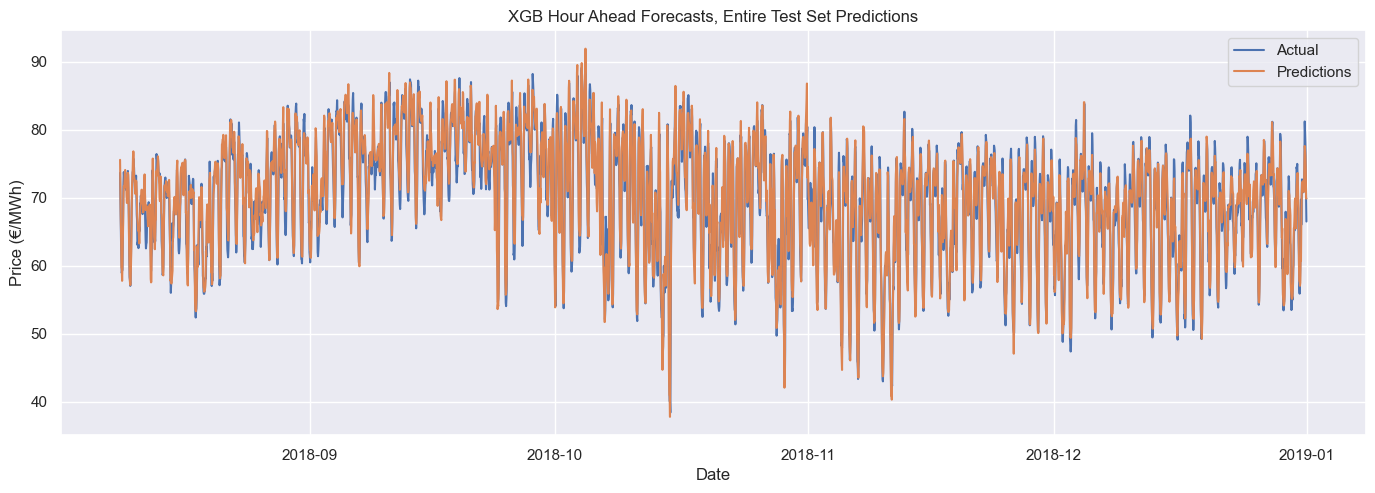

In [92]:
# Plotting data for the entire training set
plt.figure(figsize=(15,5))
plt.plot(df_test.iloc[tot_window_size_xgb_1h:].index, y_pred_test_1h_descaled, linestyle='-', label='Actual')
plt.plot(df_test.iloc[tot_window_size_xgb_1h:].index, y_test_1h_descaled, linestyle='-', label='Predictions')
plt.title('XGB Hour Ahead Forecasts, Entire Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.show()

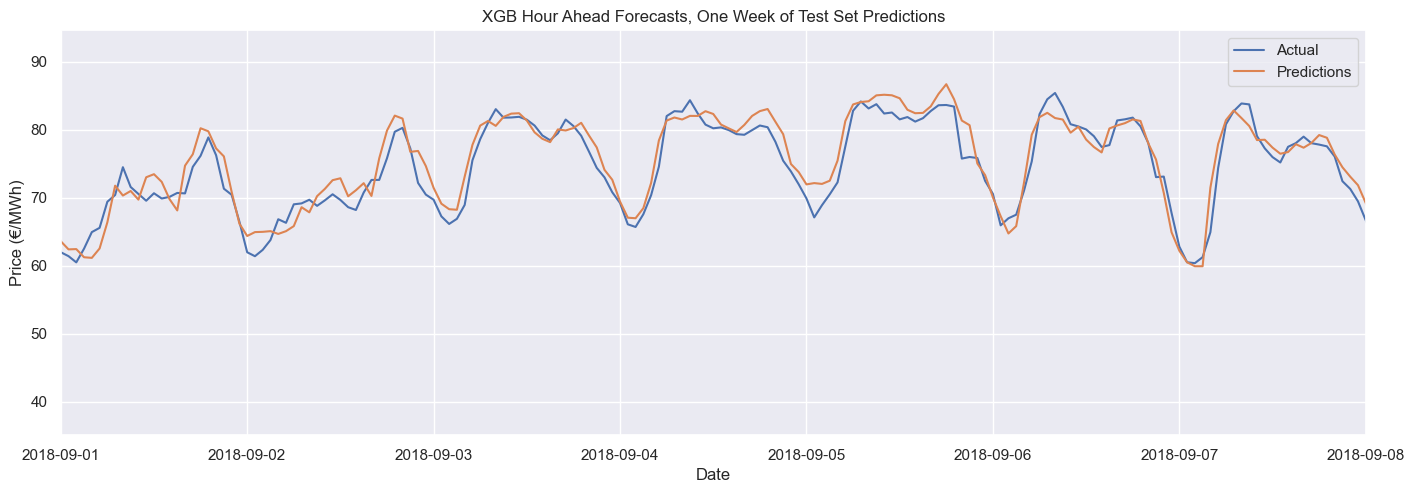

In [93]:
# Plotting data for one week of training set data
plt.figure(figsize=(15,5))
plt.plot(df_test.iloc[tot_window_size_xgb_1h:].index, y_pred_test_1h_descaled, linestyle='-', label='Actual')
plt.plot(df_test.iloc[tot_window_size_xgb_1h:].index, y_test_1h_descaled, linestyle='-', label='Predictions')
plt.title('XGB Hour Ahead Forecasts, One Week of Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh)')
plt.xlim([pd.to_datetime('09-01-2018'),
          pd.to_datetime('09-08-2018')])
plt.legend()
plt.show()

### 5.2.1 Error Metrics

In [94]:
xgb_price_rmse_1h = mean_squared_error(y_true=y_test_1h_descaled,
                                       y_pred=y_pred_test_1h_descaled,
                                       squared=False)

xgb_price_mae_1h = mean_absolute_error(y_true=y_test_1h_descaled,
                                       y_pred=y_pred_test_1h_descaled)

xgb_price_mape_1h = mean_absolute_percentage_error(y_true=y_test_1h_descaled,
                                                   y_pred=y_pred_test_1h_descaled)

print(f'The RMSE is: {xgb_price_rmse_1h:.2f}')
print(f'The MAE is: {xgb_price_mae_1h:.2f}')
print(f"The MAPE is: {xgb_price_mape_1h:.2f}%")

The RMSE is: 2.25
The MAE is: 1.70
The MAPE is: 2.45%


With a MAPE of $2.45\%$, we can conclude that our model is very accurate at predicting hour-ahead electricty prices. We will see how this compares to our deep learning models later on.

### 5.2.2 Feature Importance

An interesting feature of XGBoost is that it allows us to examine which features contribute the most to its predictions. By examining the importance of each feature, we can gain important insights on our model and use them to further understand our data.

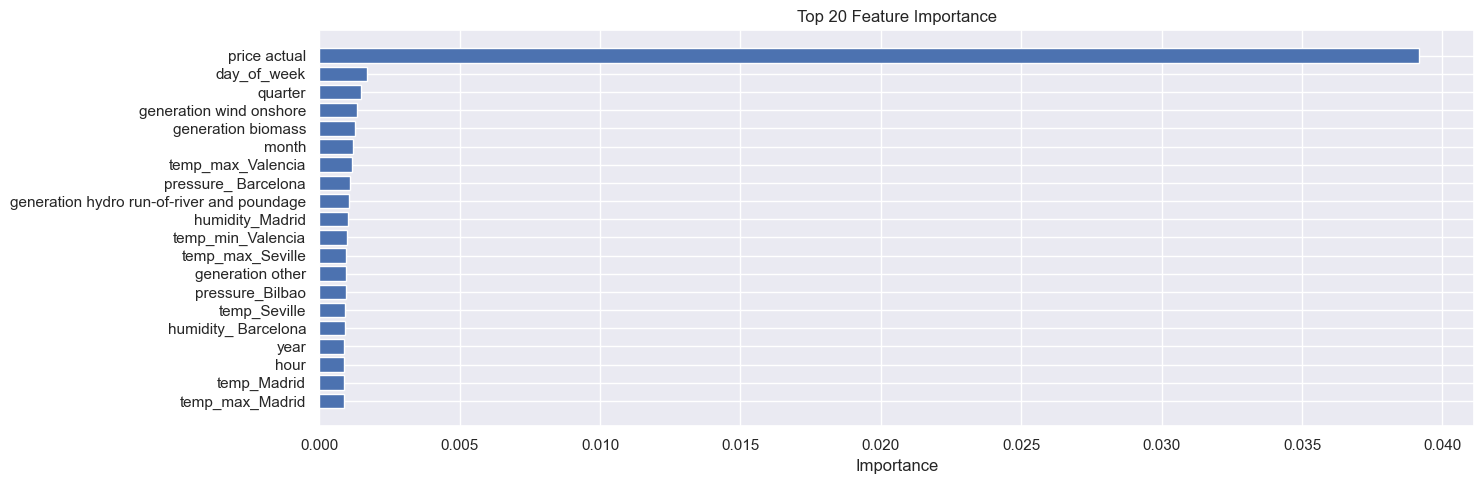

In [95]:
# Get feature importance scores
importance_scores = best_model_1h.feature_importances_

# Get feature names
feature_names = df_train.columns

# Combine feature names and importance scores
feature_importance = list(zip(feature_names, importance_scores))

# Sort by importance
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Number of top features to display
top_n = 20

# Extract top N feature names and scores
top_feature_names = [feat[0] for feat in feature_importance[:top_n]]
top_scores = [feat[1] for feat in feature_importance[:top_n]]

# Create a horizontal bar plot
plt.figure(figsize=(15, 5))
plt.barh(top_feature_names, top_scores, align='center')
plt.xlabel('Importance')
plt.title('Top {} Feature Importance'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.tight_layout()
plt.show()

Examining our top 20 most important features, we see that unsurprisingly, past values of ***price actual*** is the most accurate predictor of hour-ahead price actual. We also notive a few other interesting features:

* ***generation other renewable*** is the second best predictor of hour-ahead prices. This is not at all what I would have expected.
* ***day_of_week*** is the most important temporal feature, with ***quarter*** following closely behind. In retrospect, from analyzing our Prophet decomposition, this makes sense. The decomposition indicates that prices are higher weekdays, and that 4th quarter prices are substantially higher than other quarters. Interestingly, ***hour*** is not as important as previously thought.
* Temperature features such as ***temp_seville***, ***temp_valencia*** and ***temp_madrid*** are prominent within the most important features.
* Boolean features are nowhere to be found in the top 20 most important features. All the adjusting we did to accomadate such features may have not been entirely necessary :(

## 5.2 XGBoost - Day Ahead

We now seek to predict the day ahead prices using the previous 48h of data. To begin, we start by defining new parameters for our window function. Then, we proceed the same way as the hour ahead model.

In [97]:
window_size_xgb_24h = 48
target_len_xgb_24h = 1
gap_xgb_24h = 23

tot_window_size_xgb_24h = window_size_xgb_24h + gap_xgb_24h

In [98]:
# Generating windows
X_train_24h, y_train_24h = window_generator(dataframe=df_train, target_column='price actual',
                                    window_size=window_size_xgb_24h, target_len=target_len_xgb_24h, gap=gap_xgb_24h)

X_val_24h, y_val_24h = window_generator(dataframe=df_val, target_column='price actual', 
                                window_size=window_size_xgb_24h, target_len=target_len_xgb_24h, gap=gap_xgb_24h)

X_test_24h, y_test_24h = window_generator(dataframe=df_test, target_column='price actual', 
                                  window_size=window_size_xgb_24h, target_len=target_len_xgb_24h, gap=gap_xgb_24h)

In [100]:
# Flatten input sequences
X_train_flat_24h = X_train_24h.reshape(X_train_24h.shape[0], -1)
X_val_flat_24h = X_val_24h.reshape(X_val_24h.shape[0], -1)
X_test_flat_24h = X_test_24h.reshape(X_test_24h.shape[0], -1)

When training the model, we choose to use the same hyperparamters as from the hour ahead model. This was chosen due to the fact that optimizing hyperparameters is very computationally expensive, and will take even longer than the hour ahead model due to the use of a 48h training window for each point. Because we are using a very similar dataset and are training to predict the same variable, the hour ahead parameters should be reasonable.

In [103]:
# Train the best model on the training dataset
best_model_24h = xgb.XGBRegressor(**best_params)
best_model_24h.fit(X_train_flat_24h, y_train_24h)

# Make predictions on the test set
y_pred_test_24h = best_model_24h.predict(X_test_flat_24h)

In [104]:
# Saving model
best_model_24h.save_model('xgboost_best_model_24h.model')

In [105]:
# Inverse transformation to descale data
y_pred_test_24h_descaled = scaler_y.inverse_transform(y_pred_test_24h.reshape(-1,1))
y_test_24h_descaled = scaler_y.inverse_transform(y_test_24h)

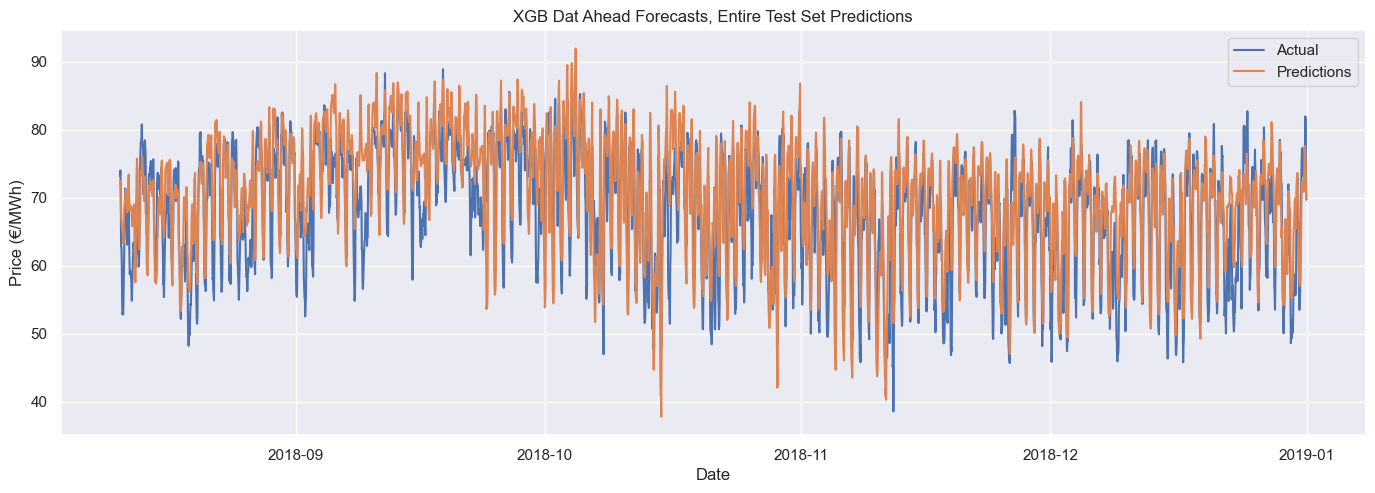

In [107]:
# Plotting data for the entire training set
plt.figure(figsize=(15,5))
plt.plot(df_test.iloc[tot_window_size_xgb_24h:].index, y_pred_test_24h_descaled, linestyle='-', label='Actual')
plt.plot(df_test.iloc[tot_window_size_xgb_24h:].index, y_test_24h_descaled, linestyle='-', label='Predictions')
plt.title('XGB Dat Ahead Forecasts, Entire Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.show()

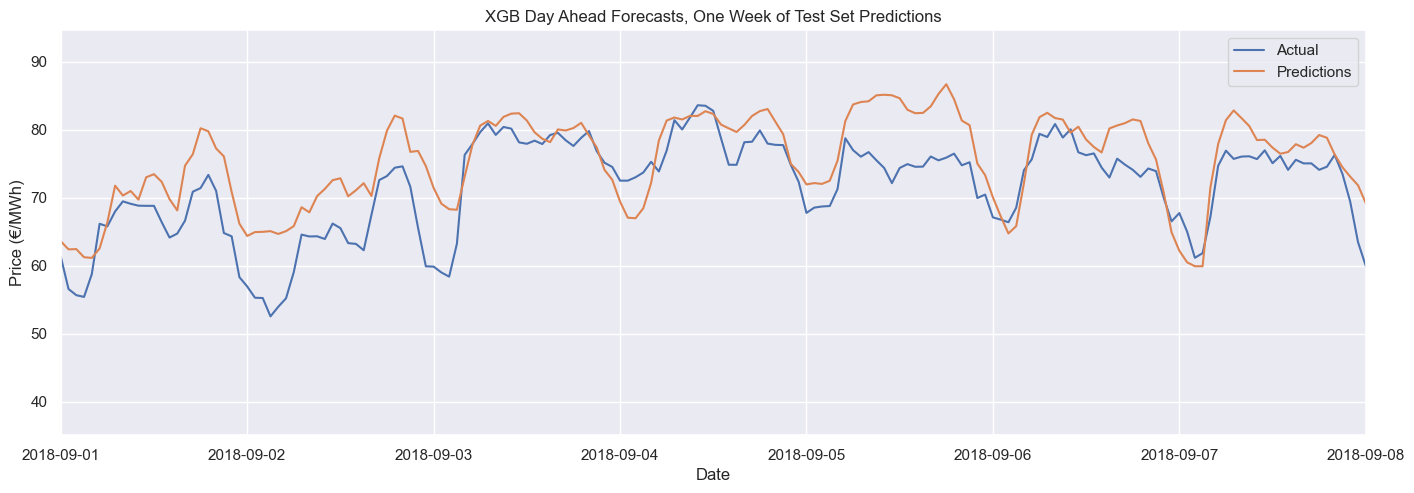

In [108]:
plt.figure(figsize=(15,5))
plt.plot(df_test.iloc[tot_window_size_xgb_24h:].index, y_pred_test_24h_descaled, linestyle='-', label='Actual')
plt.plot(df_test.iloc[tot_window_size_xgb_24h:].index, y_test_24h_descaled, linestyle='-', label='Predictions')
plt.title('XGB Day Ahead Forecasts, One Week of Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh)')
plt.xlim([pd.to_datetime('09-01-2018'),
          pd.to_datetime('09-08-2018')])
plt.legend()
plt.show()

### 5.2.1 Error Metrics

In [109]:
xgb_price_rmse_24h = mean_squared_error(y_true=y_test_24h_descaled,
                                        y_pred=y_pred_test_24h_descaled,
                                        squared=False)

xgb_price_mae_24h = mean_absolute_error(y_true=y_test_24h_descaled,
                                        y_pred=y_pred_test_24h_descaled)

xgb_price_mape_24h = mean_absolute_percentage_error(y_true=y_test_24h_descaled,
                                                    y_pred=y_pred_test_24h_descaled)

print(f'The RMSE is: {xgb_price_rmse_24h:.2f}')
print(f'The MAE is: {xgb_price_mae_24h:.2f}')
print(f"The MAPE is: {xgb_price_mape_24h:.2f}%")

The RMSE is: 5.47
The MAE is: 4.30
The MAPE is: 6.27%


As expected, the MAPE for the day ahead forecast is higher than the hour ahead. These predictions may be able to become more accurate if more than 48h of context is used, and the hyperparameters are optimized for this specific task. Nevertheless, it would make sense that predicting 24h into the future would be more difficult than predicting 1h ahead.

## 5.3 LSTM

Before we go ahead and use deep learning, we should convert our datatypes to a consistent format. By converting to float32, we have a consistent format which takes up less memory than float64.

In [802]:
# Convert object arrays to float32 arrays
X_train_DL = np.array(X_train, dtype=np.float32)
X_val_DL = np.array(X_val, dtype=np.float32)

# Convert y_train and y_val to float32 if they are not already
y_train_DL = np.array(y_train, dtype=np.float32)
y_val_DL = np.array(y_val, dtype=np.float32)

In [803]:
print("X_train:", X_train_DL.shape, X_train_DL.dtype)
print("y_train:", y_train_DL.shape, y_train_DL.dtype)
print("X_val:", X_val_DL.shape, X_val_DL.dtype)
print("y_val:", y_val_DL.shape, y_val_DL.dtype)

X_train: (24520, 24, 115) float32
y_train: (24520, 1) float32
X_val: (6989, 24, 115) float32
y_val: (6989, 1) float32


To be continued... Looking to create LSTM model, stacked LSTM, CNN, LSTM-CNN, Transformer Models (TFT), GluonTS and DeepAR. For all intents and purposes, these may be a little bit overkill, and may take a long.... time to train, but I am really looking forward to learning more about these models (especially the latter ones), and seeing how they compare in performance to XGB.

Furthermore, I really want to try something along the lines of using the last 48hrs to predict prices 24hrs in advance, then compare this to the day ahead prices and see if they are more accurate.

More to come soon!